<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-393 Máquinas de Aprendizaje II-2018 </h1>

<H3 align='center'> Tarea 1 </H3>
<hr style="height:2px;border:none"/>

## Integrantes

* Andrés Huerta - 201473544-8 - andres.huerta.14@sansano.usm.cl
* Felipe Vega - 201473511-1 - felipe.vega.14@sansano.usm.cl



<hr style="height:2px;border:none"/>


In [1]:
from IPython.display import IFrame
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
import matplotlib.pyplot as plt 
import numpy as np

A lo largo del trabajo aparecen una serie de warnings los cuales fueron ocultados debido a la estetica del entregable, aun así se encuentran comentados sus motivos.

In [2]:
#csv desde drive
#from google.colab import drive
#drive.mount('/content/drive')

# 1.- Aprendizaje con regresión lineal.

<hr style="height:2px;border:none"/>

> **a) Cargue los datos a analizar, descargándolos desde la plataforma como se indicó, en formato dataframe pandas. Descríbalos adecuadamente, ya sea la variable dependiente o las independientes, si es que lo son. **

In [3]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
df = pd.read_csv("world-university-rankings/timesData.csv")
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2603 entries, 0 to 2602
Data columns (total 14 columns):
world_rank                2603 non-null object
university_name           2603 non-null object
country                   2603 non-null object
teaching                  2603 non-null float64
international             2603 non-null object
research                  2603 non-null float64
citations                 2603 non-null float64
income                    2603 non-null object
total_score               2603 non-null object
num_students              2544 non-null object
student_staff_ratio       2544 non-null float64
international_students    2536 non-null object
female_male_ratio         2370 non-null object
year                      2603 non-null int64
dtypes: float64(4), int64(1), object(9)
memory usage: 284.8+ KB


El dataset está conformado por **2603** registros con 14 columnas cada uno. En este caso la variable dependiente es **total_score** y las demás (menos world_rank y university_name) sería las variables supuestamente independientes. Los atributos **num_students**, **students_staff**, **student_staff_ratio**, **international_students** y **female_male_ratio** poseen atributos nulos.

In [4]:
print("Valores únicos total_score: "+str(df.total_score.unique().size))

Valores únicos total_score: 415


Por otro lado, el **total_score** tiene 415 valores únicos, lo que indica que existen universidades con el mismo ranking en el dataset. 

In [5]:
print("Valores '-': " + str(df.query("total_score == '-'")['total_score'].size))



Valores '-': 1402


Dentro de los posibles valores para el **total_score** hay 1402 tienen el caracter "-", por lo que no se cuenta con su valor, es por esta razón que estos valores se utilizarán como un conjunto de pruebas final, con el objetivo de obtener una prediccción de su valor.



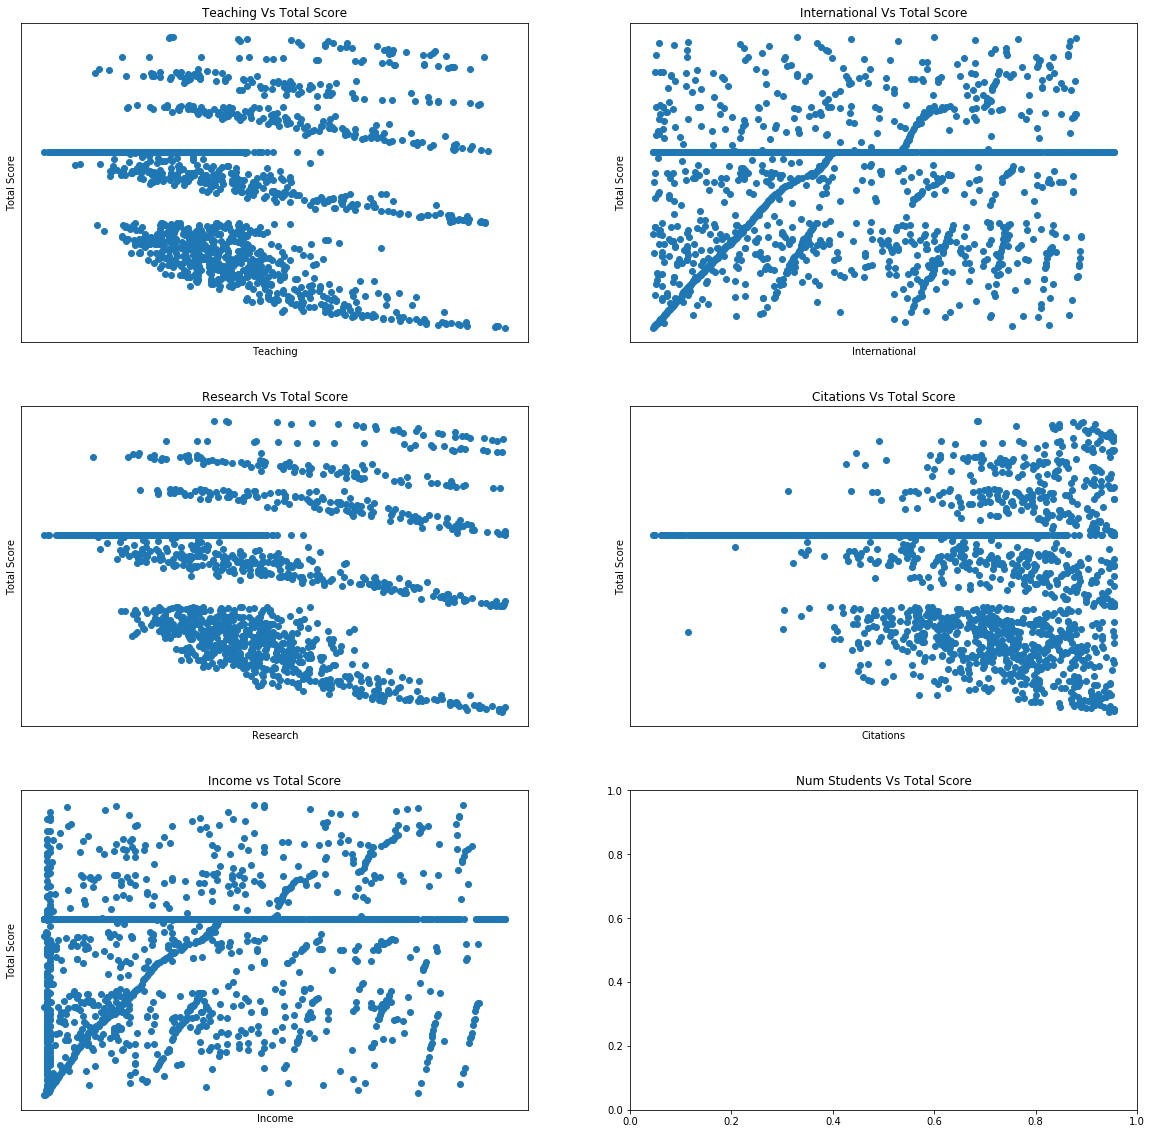

In [6]:
plt.figure(figsize=(20,20))
plt.subplot(321)
plt.title("Teaching Vs Total Score")
plt.scatter(df.teaching, df.total_score)
plt.yticks([])
plt.xticks([])
plt.xlabel("Teaching")
plt.ylabel("Total Score")
plt.subplot(322)
plt.title("International Vs Total Score")
plt.scatter(df.international, df.total_score)
plt.yticks([])
plt.xticks([])
plt.xlabel("International")
plt.ylabel("Total Score")
plt.subplot(323)
plt.title("Research Vs Total Score")
plt.scatter(df.research, df.total_score)
plt.yticks([])
plt.xticks([])
plt.ylabel("Total Score")
plt.xlabel("Research")
plt.subplot(324)
plt.title("Citations Vs Total Score")
plt.scatter(df.citations, df.total_score)
plt.yticks([])
plt.xticks([])
plt.ylabel("Total Score")
plt.xlabel("Citations")
plt.subplot(325)
plt.title("Income vs Total Score")
plt.scatter(df.income, df.total_score)
plt.yticks([])
plt.xticks([])
plt.ylabel("Total Score")
plt.xlabel("Income")
plt.subplot(326)
plt.title("Num Students Vs Total Score")
#plt.scatter(df.num_students, df.total_score)
##plt.yticks([])
#plt.ylabel("Total Score")
#plt.xlabel("Num_Students")
#plt.xticks([])
plt.show()

Analizando la distribución de los puntos para cada una de las clases presentadas se puede notar que existen 2 atributos que aparentan tener una relación mas significativa que el resto de los puntos, estos corresponden a **teaching** y **research**, a simple vista se puede ver una concentración de puntos en lo que vendria siendo una recta. Por otro lado, siguiendo la misma logica, **citations**, podría tener mayor significancia que el resto de las figuras no nombradas debido a la distribución de sus puntos.

Se sospecha que los tres atributos nombrados podrían ser los mas significativos al momento de rankear a una universidad.


Dentro de las variables independientes se encuentran **research** (puntaje por investigación, en base a cantidad, ingresos y reputación) y **citations** (puntaje por la influencia de la investigación realizada) podrían tener una relación entre si, lo que podría traer problemas en caso de calcular z-scores, porque se necesita calcular $(X^{T}X)^{-1}$ y al ser atributos linealmente dependientes el determinante sería 0, por lo que sería una matriz singular. Por esta razón se construye un scatterplot de estas dos variables.

**Por algun motivo, los gráficos obtenidos con jupyter notebook son distintos a los del colab, asi que insertamos los gráficos que deberian aparecer para su análisis.**

<img src="graficos.png">

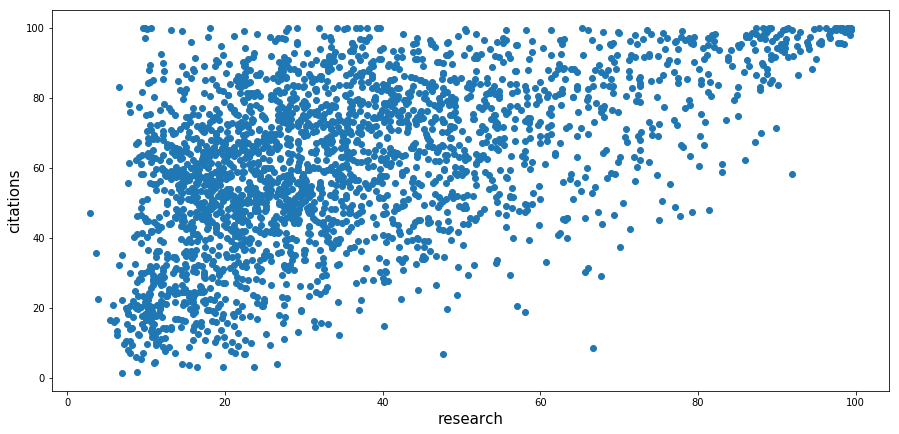

In [7]:
plt.figure(figsize=(15,7))
plt.scatter(df.research,df.citations)
plt.xlabel("research",fontsize=15)
plt.ylabel("citations",fontsize=15)
plt.show()



Considerando el gráfico, se podría dar alguna relación, pero está no está del todo clara, por lo que una vez procesados los datos se realizará un análisis de valores propios para ver si la relación de dependencia lineal existe realmente.

> **b) Debido a la estructura será necesario realizar un leve pre-proceso. Existen vacíos entre los datos o valores '-', por lo que será necesario eliminarlos. Además de ésto deje los datos con score unkown o '-' en un conjunto target separado, unlabeled data (éste será el objetivo del entrenamiento) ¿Cuántos datos quedan en cada conjunto?**

In [8]:
import numpy as np

def convertToInt(x):
    try:
        x = int(x)
    except:
        x = 0
    return x
  
df.dropna(axis=0,inplace=True,how='any') #borra nan
df["total_score"] = df["total_score"].apply(lambda x: x.replace('-','unknown')) #rellena 
df = df[~(df == '-').any(axis=1)] #elimina filas con valores nulos

nuevo_df  = pd.get_dummies(df, columns=["country"]) #column to categorical

nuevo_df['female'] = nuevo_df['female_male_ratio'].str.split(':', expand=True)[0].apply(convertToInt) #Se crea la nueva columna female y se coloca su porcentaje 
nuevo_df['male'] = nuevo_df['female_male_ratio'].str.split(':', expand=True)[1].apply(convertToInt) #Lo mismo, pero para hombres
nuevo_df['female_male_ratio'] =  np.where(nuevo_df['male'] == 0, 0, nuevo_df['female']/nuevo_df['male']) #si no hay (rellena 0) 
nuevo_df['num_students'] = nuevo_df['num_students'].apply(lambda x: int(str(x).replace(',',''))) #Se pasan el numero de estudiantes a int
nuevo_df['international_students'] = nuevo_df['international_students'].apply(lambda x: int(str(x).replace('%',''))) #se pasa el procentaje a int
print(nuevo_df.shape)


df_test = nuevo_df[nuevo_df["total_score"]=='unknown']  #para predecir al final
nuevo_df =  nuevo_df[nuevo_df["total_score"]!='unknown'] #elimina unknown rank..
print("nuevo_df: " + str(nuevo_df.shape))
print("df_test: " + str(df_test.shape))





(2174, 82)
nuevo_df: (954, 82)
df_test: (1220, 82)


Como existen valores nulos para el **total_score**, estos se separan en un set aparte para ser utilizado como un conjunto objetivo para el entrenamiento. También se obtiene el porcentaje de hombres y mujeres en base a la columna **female_male_ratio**, donde además se calcula la razón para guardar un valor flotante, además se pasan a int los valores numéricos presentes como strings en el dataset. También se generan columnas dummys para pasar la columna **country** a muchas columnas que contienen un booleano indicando si una universidad pertenece a un determinado país o no.

Una vez separados los dataset, el conjunto objetivo cuenta con 1220 registros y el conjunto con el que se trabajará cuenta con 954 registros, además, luego de transformar el atributo **country** se cuenta con 82 registros.

> **c) Cree las matrices de cada conjunto con las que trabajará. Además de ésto separe el conjunto de pruebas fijo que se utilizará, recuerde que éste no puede ser utilizado. Si estima conveniente también cree conjunto de validación. **

In [9]:
from sklearn.model_selection import train_test_split

headers = nuevo_df.columns
headers = headers.drop(["total_score","world_rank","university_name"])

Y = nuevo_df['total_score'].values #Se consiguen las Y
#nuevo_df = nuevo_df.insert(X.shape[1],'intercept',np.ones(X.shape[0]))
X = nuevo_df.drop(["total_score","world_rank","university_name"],axis=1).values #Se eliminan columnas que no aportan información para el aprendizaje

#Se obtienen los x's
X_test_unknown = df_test.drop(["total_score","world_rank","university_name"],axis=1).values #X para testing
Y = Y.astype('float32') #Se dan valores float
X = X.astype('float32')
X_test_unknown = X_test_unknown.astype('float32')
X.shape

#Se separa el conjunto de training y de testing
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
#X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.1, random_state=13)

print(X_train.shape)

X_train = np.c_[X_train, np.ones(X_train.shape[0])] #Se agrega la columna de 1 al final de X
#X_validation = np.c_[X_validation, np.ones(X_validation.shape[0])]
X_test = np.c_[X_test, np.ones(X_test.shape[0])]
X_test_unknown = np.c_[X_test_unknown, np.ones(X_test_unknown.shape[0])]

print(X_train.shape)

(667, 79)
(667, 80)


Se crean las matrices de atributos de cada conjunto, las cuales servirán como input de los modelos que se analizarán. Del conjunto rotulado se obtienen dos conjuntos, uno para entrenamiento y uno para realizar pruebas. El conjunto no-rotulado se utilizará una vez que se cuente con el modelo final a utilizar.

> **d) Normalice los datos antes de trabajar. Explique la importancia/conveniencia de realizar ésto. **

Se normalizan los datos antes de trabajar. Esto se realiza porque existen métodos que utilizan distancia euclidiana, por lo que si se tiene un atributo con valores muy grandes con respecto a los otros se producirá que las distancias se distorcionen. Además así se evita que un atributo tenga más peso que otros solo por su escala de medición.

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=True, with_std=True)
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_test_unknown_scaled = scaler.transform(X_test_unknown)

> **e) Realice una regresión lineal de mı́nimos cuadrados básica. Mida el residuo de cada predicción en cada dato y haga un gráfico de éste ¿Qué indica lo observado?**

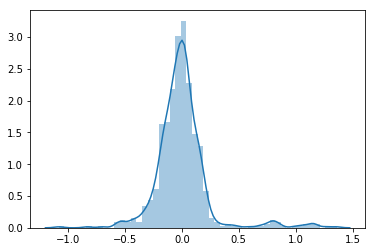

In [11]:
from sklearn.linear_model import LinearRegression as LR
import matplotlib.pyplot as plt

linreg = LR(fit_intercept=True, n_jobs=1)
linreg.fit(X_train_scaled,y_train)

import seaborn as sns
res = y_train-linreg.predict(X_train_scaled)
sns.distplot(res)
plt.show()

Una vez entrenado el modelo de regresión lineal se calculan los residuos y se grafican. Se observa que estos se distribuyen de manera similar a una distribución normal con media 0. Esto concuerda con uno de los supuestos de una regresión lineal múltiple, el cual dice que los residuos se distribuyen de manera normal con media 0 y varianza $\sigma^2$ (también es un supuesto de la regresión lineal univariada).

> **f) Construya una tabla con los pesos, Z-score y F-score correspondientes a cada predictor (variable), compare estos valores. ¿Qué sucede si hacemos un raking de los atributos en base al peso obtenido en la regresión? Compare y comente ¿Qué variables están más correlacionadas con la respuesta? Si usáramos un nivel de significación del 5%. ¿Qué es lo que observa y cuál puede ser la causa?**

Para calcular el Z-score es necesario encontrar la matriz inversa de $X^{T}X$, es por esto que se comprobarán los valores propios de esta matriz.

In [12]:
np.linalg.eigvals(np.dot(X_train_scaled.T,X_train_scaled))

array([2.70872612e+03, 1.82154278e+03, 1.70197577e+03, 1.37591875e+03,
       1.02796830e+03, 1.54652610e+01, 3.11540633e+01, 5.45424670e+01,
       1.68582950e+02, 1.05026155e+02, 1.07769343e+02, 2.25727573e+02,
       9.24370212e+02, 2.99760847e+02, 4.29592865e+02, 7.88597428e+02,
       5.52300038e+02, 5.61817188e-13, 1.14953953e-13, 5.96794377e+02,
       7.37419853e+02, 7.27670317e+02, 7.09515805e+02, 7.03235243e+02,
       6.97469806e+02, 6.92387257e+02, 6.86620101e+02, 6.84373625e+02,
       6.81258659e+02, 6.79881523e+02, 6.78327198e+02, 6.77049796e+02,
       6.75860223e+02, 6.76425707e+02, 6.68486272e+02, 6.73360896e+02,
       6.69477620e+02, 6.72704257e+02, 6.71652901e+02, 6.70202396e+02,
       6.71260835e+02, 6.70689036e+02, 6.69855364e+02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

Se observan que existen varios valores propios igual a 0, por lo que existen varios atributos en esta matriz que son linealmente dependientes. Como la función utilizada no entrega los valores propios ordenados, encontrar la dependencia entre los atributos consumirá mucho tiempo. Por esta razón se utilizará una matriz _pseudo inversa_ que se calcula a partir de una descomposición de valores singulares.

### Calculo del Z-Score

Para calcular el Z-Score se utilizó la siguiente fórmula

$$ z_j = \frac{\hat{\beta_j}}{\hat{\sigma}\sqrt{v_j}}$$
Donde $\hat{\beta_j}$ es el coeficiente encontrado por el modelo para el atributo $j$, $\hat{\sigma}$ es la desviación estándar estimada de los residuos del modelo.

$$ \hat{\sigma}^2 = \frac{1}{N - p - 1}\sum_{i = 1}^{N}(y_i - \hat{y_i})^2$$

El denominador utilizado es para que el estimador de la varianza sea insesgado.

Por último $v_j$ se obtiene desde la diagonal de una pseudo matriz de covarianzas, la cual se calcula de la siguiente manera.

$$ v_j = (X^{T}X)^{-1}[j][j]$$

In [13]:
from scipy import stats

#linreg.intercept_
def zscores(model, X, Y):
  #Pesos del modelo
  pesos = model.coef_
  #Calculo varianza estimada del error
  Y_predict = model.predict(X)
  deltas = Y - Y_predict
  deltas = deltas*deltas
  sigma2 = sum(deltas)/(len(Y_predict)- len(pesos) - 1)
  #Desviación estimada del error
  sigma = sigma2**0.5
  #Matriz de covarianzas
  XT = np.transpose(X)
  dotMatrix = np.dot(XT,X)
  pseudoCovMatriz = np.linalg.pinv(dotMatrix)
  #Calculo del Z-Score
  ZScores = []
  for i in range(len(pesos)):
    ZScores.append(pesos[i]/(sigma * (pseudoCovMatriz[i][i]**0.5)))
  return ZScores  
  
scores = zscores(linreg,X_train_scaled,y_train)   

print(scores)

[152.09103980367243, 50.699607605559414, 190.53261707826132, 304.95782979973905, 42.4080318629398, -1.9056495375316909, 0.07362108352058708, 0.659455571798736, 0.8116614499890761, -4.267433950574045, -2.5023558805717555e+28, -89512756642944.16, -42598927205113.94, 3.4715850254283734e+28, -65879510812771.17, -25517392964494.133, -93692343804263.78, -1.0059834869342231e+29, -47077941514758.25, 1.9452363158223453e+29, 3.8583005501709254e+29, 8.525472800389918e+28, -61586748895124.94, -17531397734911.814, nan, -35563878263517.2, -79930716318527.58, -90746630367364.92, -5.245296888285301e+30, -63235294806475.9, 2.1719254350922671e+30, -5.788765962050459e+30, -3.1457101848945785e+30, 1.1285633888938795e+30, -1.8294372324463885e+30, -32579616740205.22, -31731126040680.062, -50713239560844.625, nan, nan, 1.488481053859087e+31, inf, -18847110343183.83, inf, -inf, -inf, -inf, -115184993780032.58, -36724092711636.43, nan, -32639141565285.914, nan, nan, nan, nan, nan, -32889089660182.414, nan, -18

# Cálculo del F-Score

En el caso del F-Score, este se calcula en base a tres varianzas (fuentes de error).

Sea $$SST = SSR_i + SSE_i$$

Donde SST suma de cuadrados total, SSR es una suma de cuadrados asociada a la regresión y SSE es una suma de cuadrados del error. 

El F-Score se puede calcular de la siguiente manera

$$ F(i) = \frac{\frac{SSR(i)}{1}}{\frac{SSE(i)}{n - 2}} = \frac{\frac{SSR(i)}{SST}}{\frac{SSE(i)}{SST(n - 2)}} = (n- 2)\frac{\frac{SSR(i)}{SST}}{1 - \frac{SSR(i)}{SST}} = \frac{(n - 1)\rho(i)^2}{(1 - \rho(i)^2)}$$

Donde $\rho(i)$ es el coeficiente de correlación de Pearson

$$ \hat{\rho(i)} = \frac{\sum_{l} (x_i^{(l)} - \bar{x_i})(y^{(l)} - \bar{y})}{\sqrt{\sum_{l} (x_i^{(l)} - \bar{x_i})^2} \sqrt{\sum_{l}(y^{(l)} - \bar{y})^2}}$$

In [14]:

def fscores(X, Y):
  scores = []
  #Obtener medias por columnas
  X_means = np.mean(X, axis = 0)
  #Obtener media de y
  y_mean = np.mean(Y)
  # x - xmean
  x_delta = X - X_means.T
  # y - ymean
  y_delta = Y - y_mean
  y_delta2 = y_delta * y_delta
  
  xaux = []
  xaux2 = []
  
  for i in range(x_delta.shape[0]):
    xaux.append((x_delta[i]*y_delta[i]))
    xaux2.append(x_delta[i]*x_delta[i])
  
  num = sum(xaux)
  dem1 = sum(xaux2)**0.5
  dem2 = sum(y_delta2)**0.5
  scores = num/(dem1*dem2)
  return scores

fscore = fscores(X_train_scaled, y_train)

In [15]:
d = {'zscores': scores, 'fscores':fscore}
scoresDF = pd.DataFrame(d)

scoresDF.index = headers.append(pd.Index(["Intercept"]))
display(scoresDF)



,zscores,fscores
teaching,1.520910e+02,0.907445
international,5.069961e+01,0.115360
research,1.905326e+02,0.907219
citations,3.049578e+02,0.575996
income,4.240803e+01,0.234237
num_students,-1.905650e+00,-0.016688
student_staff_ratio,7.362108e-02,-0.278798
international_students,6.594556e-01,0.236483
female_male_ratio,8.116614e-01,-0.151894
year,-4.267434e+00,0.044525


Considerando el F-Score, los mejores atributos serían teaching y research. ** TEST DE HIPÓTESIS PENDIENTE **

> **g) Calcule la información mútua de los distintos predictores (variables) con respecto a la variable output o target. Comente con lo calculado anteriormente y se le parece razonable.**

Se calcula la información mútua para cada predictor con respecto a la variable output.

In [16]:
from sklearn.feature_selection import mutual_info_regression
minfo_predictor = mutual_info_regression(X_train_scaled,y_train)

ifData = pd.DataFrame({'mutual_info': minfo_predictor})
ifData.index = headers.append(pd.Index(["Intercept"]))
display(ifData)

,mutual_info
teaching,0.890516
international,0.070099
research,0.924808
citations,0.297818
income,0.123372
num_students,0.220593
student_staff_ratio,0.240616
international_students,0.271291
female_male_ratio,0.310896
year,0.215927


Se observa que nuevamente las columnas **teaching** y **research** obtienen una mejor información mutua, al igual que en el caso del F-Score. Además, no existen valores 0 para la información mutua, por lo que existe dependencia entre los predictores y la variable objetivo.

> **h) Construya una función que implemente Forward Step-wise Selection (FSS). Es decir, partiendo con un modelo sin predictores (variables), agregue un predictor a la vez, re-ajustando el modelo de regresión en cada paso. Para seleccionar localmente una variable, proponga/implemente un criterio distinto al utilizado en el código de ejemplo. Construya un gráfico que muestre el error de entrenamiento y el error de pruebas como función del número de variables en el modelo. Ordene el eje  $x$  de menor a mayor.**

Se cambia el criterio de selección de MSE a un $R^2$ ajustado, debido a que el coeficiente de determinación indicará que tan buenas pueden ser nuestras predicciones futuras. Se utiliza la variante ajustada  debido a que esta penaliza si se agrega un atributo poco útiles para el modelo, cosa que el $R^2$ normal no realiza.

$$ R_{adj}^2 = 1 - \frac{(1 - R^2)(n - 1)}{n - k - 1}$$

Con $n$ el número de ejemplos, $k$ es el número de atributos del modelo y $R^2$ el coeficiente de determinación.

De esta manera, el atributo a seleccionar será aquel que obtenga un mejor $R^2$ ajustado.

In [17]:
from sklearn.metrics import r2_score as R2

def fss(x, y, names_x,x_test,y_test,k = 10000):
    p = x.shape[1]-1
    k = min(p, k)
    names_x = np.array(names_x)
    remaining = [x for x in range(0, p)]
    selected = [p]
    current_score = best_new_score = 0.0
    
    dimensiones = []
    scores = []
    testScores = []
    errorTraining = []
    while remaining and len(selected)<=k :
        score_candidates = []
        score_candidates_test = {}
        error_candidates = {}
        for candidate in remaining:
            model = LR(fit_intercept=True, n_jobs=1)
            indexes = selected + [candidate]
            x_train = x[:,indexes]
            xtest = x_test[:,indexes]
            
            predictions_train = model.fit(x_train, y).predict(x_train)
            predictions_test = model.predict(xtest)
            
            residuals_train = predictions_train - y
            residuals_test = predictions_test - y_test
            
            #Criterio Código
            mse_candidate = np.mean(np.power(residuals_train, 2))
            mse_test = np.mean(np.power(residuals_test, 2))
            
            #Criterio R2 ajustado
            r2_candidate = R2(y, predictions_train) 
            n = X_train.shape[0]
            r2adj_candidate = 1 - (((1 - r2_candidate)*(n - 1))/(n - len(indexes) - 1))
            
            #score_candidates.append((mse_candidate, candidate))
            score_candidates.append((r2adj_candidate, candidate))
            score_candidates_test[candidate] = mse_test
            error_candidates[candidate] = mse_candidate
        score_candidates.sort()
        #score_candidates[:] = score_candidates[::-1]
        #print(score_candidates)
        best_new_score, best_candidate = score_candidates.pop()
        
        testScores.append(score_candidates_test[best_candidate])
        errorTraining.append(error_candidates[best_candidate])
        remaining.remove(best_candidate)
        selected.append(best_candidate)
        dimensiones.append(len(selected))
        scores.append(best_new_score)
        #print("selected = %s ..."%names_x[best_candidate])
        #print("totalvars=%d, mse = %f"%(len(indexes),best_new_score))
    return selected, dimensiones, scores, testScores, errorTraining
names_regressors = nuevo_df.drop(["total_score","world_rank","university_name"],axis=1).columns
selected, d, scores, tscores, etrain = fss(X_train_scaled,y_train,names_regressors, X_test_scaled, y_test)
print(len(selected))

80


Se grafica el MSE para el conjunto de entrenamiento y el de pruebas versus la cantidad de dimensiones utilizadas.

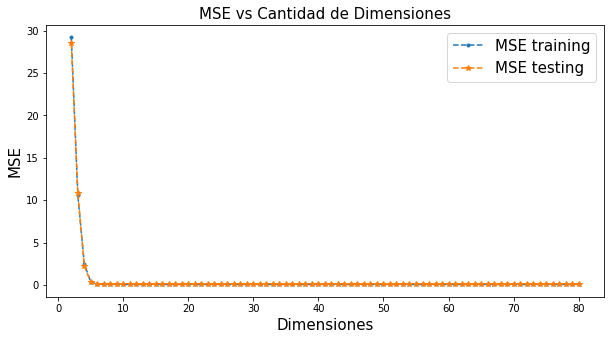

[0.8229240847602909, 0.9356274918599231, 0.985138401017033, 0.9977951844149403, 0.9995763874463081, 0.9996055347185075, 0.9996262651948854, 0.9996365840689719, 0.9996382839352924, 0.9996396993409108, 0.9996404054811361, 0.9996410755536973, 0.99964159177278, 0.999642372703846, 0.9996427797388829, 0.9996429595168709, 0.9996429018924389, 0.9996429733994876, 0.9996429997799838, 0.9996429553736614, 0.9996430161829446, 0.9996427731066548, 0.999642436764613, 0.9996420492325451, 0.9996416352142397, 0.9996411901665551, 0.9996407238718961, 0.9996402530961077, 0.9996397454934434, 0.9996393258745538, 0.9996388275913369, 0.999638319269612, 0.9996378118320061, 0.9996372606931324, 0.9996366953337269, 0.9996361233213239, 0.9996355472956834, 0.9996349681070289, 0.9996343878038302, 0.9996338028243162, 0.9996332159698681, 0.999632627231457, 0.9996320365999962, 0.9996314441135511, 0.9996308434268392, 0.9996302471140621, 0.9996296488084215, 0.9996290485633784, 0.9996284463694878, 0.9996278422172431, 0.9996

In [18]:
plt.figure(figsize=(10,5))
plt.title("MSE vs Cantidad de Dimensiones",fontsize=15)
plt.ylabel("MSE",fontsize=15)
plt.xlabel("Dimensiones",fontsize=15)
plt.plot(d,etrain,'.--')
plt.plot(d,tscores,'*--')
plt.legend(["MSE training","MSE testing"], prop={'size':15})
#plt.axis([0,10,0,3])
plt.show()

print(scores)
print(tscores)
print(selected)

Se ve que el error de entrenamiento y el error de pruebas se comportan de manera similar, además el error llega casi a 0 cuando se encuentran seleccionadas las variables teaching y research, lo que concuerda con los análisis realizados en las preguntas anteriores.

> **i) Ajuste un modelo lineal utilizando “Ridge Regression”, es decir, regularizando con la norma  $l2$. Utilice valores del parámetro de regularización  $\lambda$  en el rango $[10^0, 10^6 ]$, variando si estima conveniente. Construya un gráfico que muestre los coeficientes obtenidos como función del parámetro de regularización. Deje un gráfico sólo para analizar los coeficientes de los países. Describa lo que observa **

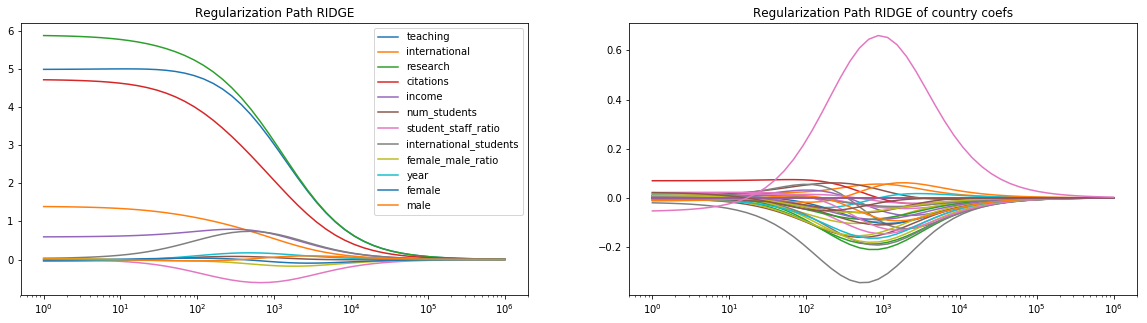

In [19]:
from sklearn.linear_model import Ridge
import matplotlib.pylab as plt
names_regressors = nuevo_df.drop(["total_score","world_rank","university_name"],axis=1).columns
alphas_ = np.logspace(0,6,base=10)
coefs = []
model = Ridge(fit_intercept=True,solver='svd')
for a in alphas_:
    model.set_params(alpha=a)
    model.fit(X_train_scaled, y_train)
    coefs.append(model.coef_)
plt.figure(figsize=(20,5))
ax = plt.gca()

plt.subplot(121)
for y_arr, label in zip(np.squeeze(coefs).T, names_regressors):
    if "country" not in label:
        plt.plot(alphas_, y_arr, label=label)
plt.xscale('log')
plt.title('Regularization Path RIDGE')
plt.legend()
#plt.show()
#...#modify
plt.subplot(122)
for y_arr, label in zip(np.squeeze(coefs).T, names_regressors):
  if "country" in label:
    plt.plot(alphas_, y_arr, label=label)
plt.title('Regularization Path RIDGE of country coefs')
plt.xscale("log")
plt.show()

Se entrena un modelo **Ridge** (regresión lineal regularizada con norma l2). Al variar el parámetro de regularización del modelo se ve como lentamente se van filtrando los atributos a utilizar, donde los últimos en ser filtrados son teaching, research y citations. La misma situación se observa para los atributos asociados al país de la universidad, sin embargo se observa que un país se dispara al utilizar un parámetro de regularización del orden de $10^3$.

> **j) Ajuste un modelo lineal utilizando el método “Lasso”, es decir, regularizando con la norma  $l1$ . Utilice valores del parámetro de regularización  $\lambda$  en el rango $[10^2, 10^3]$. Para obtener el código, modifique el ejemplo anterior. Construya un gráfico que muestre los coeficientes obtenidos como función del parámetro de regularización. Describa lo que observa. ¿Es más efectivo Lasso para seleccionar atributos?**

Se realiza el mismo ejercicio anterior pero para el método Lasso (regresión lineal regularizada con norma $l_1$)

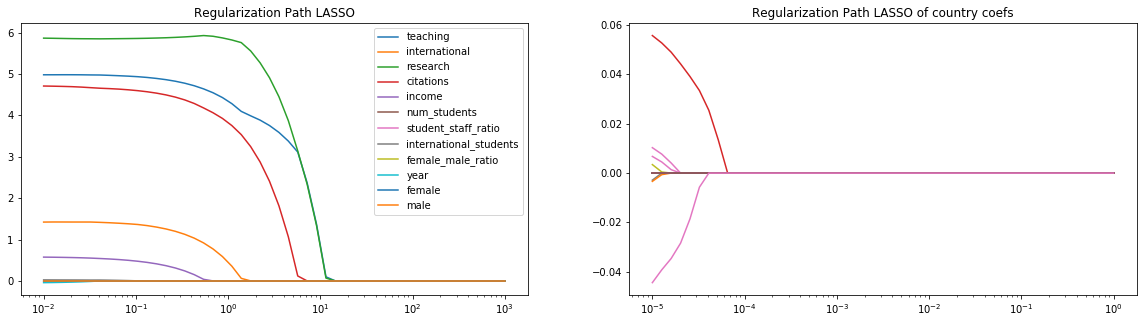

In [20]:
from sklearn.linear_model import Lasso

names_regressors = nuevo_df.drop(["total_score","world_rank","university_name"],axis=1).columns
alphas_ = np.logspace(-2,3,base=10)
coefs = []
model = Lasso(fit_intercept=True)
for a in alphas_:
    model.set_params(alpha=a)
    model.fit(X_train_scaled, y_train)
    coefs.append(model.coef_)
plt.figure(figsize=(20,5))
ax = plt.gca()

plt.subplot(121)
for y_arr, label in zip(np.squeeze(coefs).T, names_regressors):
    if "country" not in label:
        plt.plot(alphas_, y_arr, label=label)
plt.xscale('log')
plt.title('Regularization Path LASSO')
plt.legend()
#plt.show()
#...#modify
plt.subplot(122)
country_alphas_ = np.logspace(-5,0,base=10)
for y_arr, label in zip(np.squeeze(coefs).T, names_regressors):
  if "country" in label:
    plt.plot(country_alphas_, y_arr, label=label)
plt.title('Regularization Path LASSO of country coefs')
plt.xscale("log")
plt.show()



Se observa que el filtrado es mucho más brusco que en el caso del método Ridge, por lo que Lasso es mejor para el filtrado de atributos. Además en el caso de los atributos de países, el filtrado se hace casi de manera inmediata, indicando que no son atributos importantes para el calculo del ranking.

> **k) Escogiendo uno de los dos métodos regularizadores anteriores, especificando el porqué, construya un gráfico que muestre el error de entrenamiento y el de pruebas como función del parámetro de regularización. Discuta lo que observa.**

Se escoje el método Lasso, debido a que filtra de mejor manera los atributos, lo cual es bueno, debido a que todos los análisis anteriores han llegado a la conclusión que 3 atributos (teaching, research y citations) son los que funcionan de mejor manera con respecto a los otros.

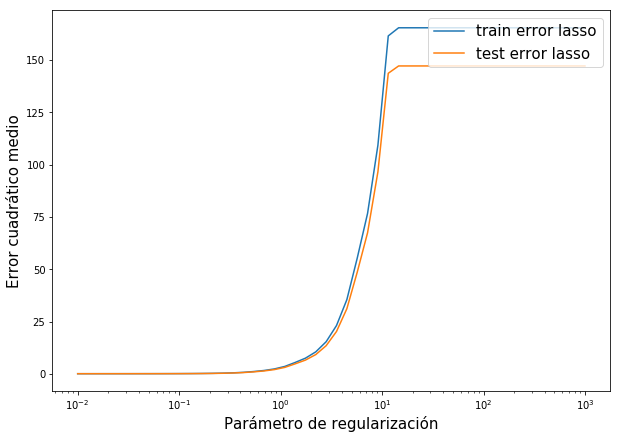

In [21]:
plt.figure(figsize=(10, 7))
alphas_ = np.logspace(-2,3,base=10)
coefs = []
model = Lasso(fit_intercept=True)
mse_test = []
mse_train = []
for a in alphas_:
    model.set_params(alpha=a)
    model.fit(X_train_scaled, y_train)
    yhat_train = model.predict(X_train_scaled)
    yhat_test = model.predict(X_test_scaled)
    mse_train.append(np.mean(np.power(yhat_train - y_train, 2)))
    mse_test.append(np.mean(np.power(yhat_test - y_test, 2)))
ax = plt.gca()
ax.plot(alphas_,mse_train,label='train error lasso')
ax.plot(alphas_,mse_test,label='test error lasso')
plt.legend(loc=1, prop={'size':15})
ax.set_xscale('log')
#ax.set_xlim(ax.get_xlim()[::-1])
plt.xlabel("Parámetro de regularización",fontsize=15)
plt.ylabel("Error cuadrático medio",fontsize=15)
plt.show()

En el gráfico de error cuadrático medio versus el parámetro de regularización, se observa un bajo error de entrenamiento y testing hasta que se utiliza un parámetro entre 1 y 10, donde el error se dispara. Se observa además que el error de testing es menor que el error de training en la gran mayoría de los casos. También se observa que el error de entrenamiendo aumenta a medida que aumenta el valor del parámetro de regularización, por lo que de elegir un parámetro habría que confiar en un método como cross-validation.

> **l) Estime el valor del parámetro de regularización en alguno de los modelos anteriores haciendo uso de la técnica validación cruzada con un número de folds igual a  $K=5$  y $K=10$ . Recuerde que para que la estimación sea razonable, en cada configuración (fold) deberá reajustar los pesos del modelo. Mida el error real del modelo (ésto es sobre el conjunto de pruebas). Debido a la escala del error puede utilizar auxiliarmente MAE como métrica de desempeño. Compare y concluya.**

Se utiliza el modelo Lasso para encontrar una estimación del parámetro de regularización utilizando K-Fold crossvalidation, utilizando $K = 5$ y $K = 10$. Debido a la escala de los errores se utilizará MAE como métrica de desempeño.

In [22]:
from sklearn.model_selection import KFold
#Parámetros Regularizadores a utilizar
alphas_ = np.logspace(-2,3,base=10)

def estimatedKFOLD(K):
  MAEalphas = []
  NonZeros = []
  for i in alphas_:
    #Inicialización del modelo Lasso
    model = Lasso(fit_intercept=True)
    #Elegir parámetro de regularización
    model.set_params(alpha=i)
    #Ajuste del modelo
    model.fit(X_train_scaled, y_train)
    
    #LETS DO THE K-FOLD!
    mae_cv = 0
    non_zeros = 0
    kf = KFold(n_splits=K)
    for train, val in kf.split(X_train_scaled):
      #Re-Ajuste del modelo
      model = Lasso(fit_intercept=True)
      model.set_params(alpha=i)
      model.fit(X_train_scaled[train], y_train[train])
      #Predicción del fold
      yhat_kfold_val = model.predict(X_train_scaled[val])
      #Cálculo del MAE
      mae_fold = np.mean(np.abs(yhat_kfold_val - y_train[val]))
      mae_cv += mae_fold
      non_zeros += np.count_nonzero(model.coef_)
    mae_cv = mae_cv/K
    non_zeros = non_zeros/K
    NonZeros.append(non_zeros)
    MAEalphas.append(mae_cv)
  return MAEalphas, NonZeros


In [23]:
#K = 5
estimacionK5, nonZK5 = estimatedKFOLD(5)
#K = 6
estimacionK10, nonZK10 = estimatedKFOLD(10)


In [24]:
d = {'alpha':alphas_,'K5 MAE': estimacionK5,'K10 MAE': estimacionK10}
dataEstimated = pd.DataFrame(d)
print("MAE mínimo K5")
dataEstimated.sort_values('K5 MAE')
display(dataEstimated.head(1))
print("MAE mínimo K10")
dataEstimated.sort_values('K10 MAE')
dataEstimated.head(1)


MAE mínimo K5


,alpha,K5 MAE,K10 MAE
0,0.01,0.151563,0.150709


MAE mínimo K10


,alpha,K5 MAE,K10 MAE
0,0.01,0.151563,0.150709


Los mejores resultados, considerando el conjunto de pruebas, se obtienen en ambos casos para un parámetro de regularización igual a 0.01. Además se ve que se obtienen mejores resultados utilizando $K = 10$.

> **m) Con el modelo que se piense que es el mejor, en base a todo lo experimentado. Realice el ranking de las universidades del que no se tienen etiquetas (unlabeled data o target data) a través de predecir los datos que se dejaron como pruebas y ordenar su score en el dataframe.**

Se utilizará el modelo Lasso con un parámetro de regularización de 0.01, debido a que es el modelo con el que más de experimentó en las preguntas anteriores. Se genera un ranking de universidades para el conjunto no rotulado. Debido a la cantidad de universidades no rotuladas, se realiza un ranking para las universidades chilenas no rotuladas.

In [25]:
#VAMOS CON LASSO CON ALPHA = 0.01
lasso = Lasso(fit_intercept=True)
a = 0.1
lasso.set_params(alpha=a)
lasso.fit(X_train_scaled, y_train)
df_test["total_score"] = lasso.predict(X_test_unknown_scaled)

univ_chilenas = df_test[df_test["country_Chile"]==1]
rannking_univ_ch = univ_chilenas.sort_values(by="total_score",ascending=False)
ranking = 1
for index,row in rannking_univ_ch.iterrows():
    print("%d - Institucion: %s - Score: %s" %(ranking,row["university_name"],row["total_score"]))
    ranking+=1


1 - Institucion: Federico Santa María Technical University - Score: 41.47750742780691
2 - Institucion: Federico Santa María Technical University - Score: 34.56401078275823
3 - Institucion: Austral University of Chile - Score: 17.14326170575186
4 - Institucion: University of Santiago, Chile (USACH) - Score: 16.17945544557881
5 - Institucion: Pontifical Catholic University of Valparaíso - Score: 15.452880407520496


Se puede ver que la mejor universidad chilena no rotulada es la Universidad Técnica Federico Santa María, seguida de la Universidad Austral, la Universidad Católica de Valparaíso y la USACH. 

# 2.- Análisis de audios como datos brutos
<hr style="height:2px;border:none"/>

In [26]:
#trabajo sobre archivos wav
from scipy.io import wavfile

def clean_filename(fname, string):
  file_name = fname.split('/')[1]
  if file_name[:2] == '__':
    file_name = string + file_name
  return file_name

SAMPLE_RATE = 44100

def load_wav_file(name, path):
  s, b = wavfile.read(path + name)
  assert s == SAMPLE_RATE
  return b

> **a) Construya un dataframe con los datos a analizar. Describa el dataset y determine cuántos registros hay por clase.**

In [27]:
#importar dataset
import pandas as pd
import numpy as np
data = pd.read_csv('hearthbeat-sounds/set_a.csv')

In [28]:

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176 entries, 0 to 175
Data columns (total 4 columns):
dataset     176 non-null object
fname       176 non-null object
label       124 non-null object
sublabel    0 non-null float64
dtypes: float64(1), object(3)
memory usage: 5.6+ KB


Se observa que el dataset tiene 176 registros con  4 atributos: _**dataset**_, _**fname**_, _**label**_ y _**sublabel**_. De los cuatro, _**label**_ tiene 52 valores nulos y sublabel tiene todos sus valores nulos.

In [29]:
d = {'Valores Unicos':[data.dataset.unique().size,data.fname.unique().size,data.label.unique().size,data.sublabel.unique().size]}
uniqueValues = pd.DataFrame(d, columns=["Valores Unicos"])
uniqueValues.index = data.columns
display(uniqueValues)

labelValues = pd.DataFrame(data.label.unique(), columns=["label"])
display(labelValues)

print("Valores Nulos: "+str(data.label.isna().sum()))

,Valores Unicos
dataset,1
fname,176
label,5
sublabel,1


,label
0,artifact
1,extrahls
2,murmur
3,normal
4,NaN


Valores Nulos: 52


Además, la columna _**label**_ tiene 4 posibles valores: _artifact_, _extrahls_, _murmur_, _normal_, donde también existen 52 registros sin valor.

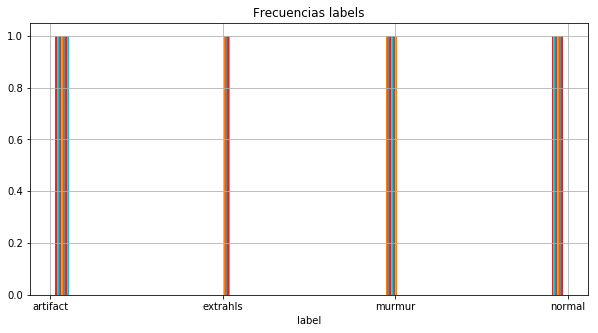

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.title("Frecuencias labels")
plt.xlabel("label")
data.label.hist()
plt.show()

Se observa que _artifact_ es el valor que más aparece en el dataset, seguido de murmur, normal y extrahls.

> **b) Lea los archivos .wav y transformelos en secuencias de tiempo. Realice un padding de ceros al final de cada secuencia para que todas queden representadas con la misma cantidad de elementos, explique la importancia de realizar este paso.**

In [31]:
def padd_zeros(array, length):
  aux = np.zeros(length)
  aux[:array.shape[0]] = array
  return aux

new_data = pd.DataFrame({'file_name': data['fname'].apply(clean_filename, string='Aunlabelledtest')})
new_data['time_series'] = new_data['file_name'].apply(load_wav_file, path='hearthbeat-sounds/set_a/')
new_data['len_series'] = new_data['time_series'].apply(len)
new_data['time_series'] = new_data['time_series'].apply(padd_zeros, length=max(new_data['len_series']))

Es necesario pasar los archivos de audio a un formato que sirva para realizar trabajos y extraer la información que servirá como entrada del modelo, es por esto que cada audio se transforma a series de tiempo. Como estos datos no tienen la misma cantidad de componentes, es necesario agregar ceros al final de cada registro (sin contar la serie de tiempo más grande) para que así todos los registros tengan la misma cantidad de elementos y no trabajar con una matriz con valores nulos.

> **c) Manipule los datos y cambie las etiquetas de los audios por otras asignadas por un doctor experto, el cual afirma que estos cambios son requeridos. Vuelva a determinar cuántos registros hay por clase. Nótese que ahora son 3 clases ¿Explique la problemática de tener etiquetas mal asignadas en los datos? ¿Un solo dato puede afectar esto?**

In [32]:
new_labels = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 0, 2, 2, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

labels = ['artifact', 'normal/extrahls', 'murmur']
new_data['target'] = [labels[i] for i in new_labels]

display(new_data['target'].value_counts())
print(new_data.target.unique())
print("Valores nulos: "+ str(new_data.target.isna().sum()))

new_data.head()

normal/extrahls    65
artifact           58
murmur             53
Name: target, dtype: int64

['artifact' 'murmur' 'normal/extrahls']
Valores nulos: 0


,file_name,time_series,len_series,target
0,artifact__201012172012.wav,"[1.0, -3.0, -1.0, -7.0, -9.0, -2.0, -6.0, -5.0...",396900,artifact
1,artifact__201105040918.wav,"[-2.0, 3.0, -4.0, 4.0, -3.0, 2.0, -1.0, 0.0, 0...",396900,artifact
2,artifact__201105041959.wav,"[6.0, -4.0, -9.0, -1.0, -4.0, 1.0, -5.0, 2.0, ...",396900,artifact
3,artifact__201105051017.wav,"[-85.0, -198.0, -214.0, -173.0, -177.0, -206.0...",396900,artifact
4,artifact__201105060108.wav,"[53.0, -35.0, 47.0, 170.0, 340.0, 436.0, 535.0...",396900,artifact


Se cambian las etiquetas por unas determinadas por un experto [1]. De esta manera existen solo 3 clases, además ya no existen valores sin etiqueta en la muestra. 

El hecho de tener etiquetas mal asignadas alteraría el entrenamiento, provocando que se realicen predicciones erroneas en la práctica. 

Uno solo dato erroneo puede afectar o no dependiendo del modelo que se utilice, por ejemplo un modelo basado en definir hiperplanos separadores como el Perceptrón, donde dicho dato mal etiquetado moverá la frontera de separación.

> **d) Codifique las distintas clases a valores numéricos para que puedan ser trabajados por los algoritmos clasificadores **

In [33]:
new_data['target'] = new_data['target'].astype('category')
cat_columns = new_data.select_dtypes(['category']).columns
new_data[cat_columns] = new_data[cat_columns].apply(lambda x: x.cat.codes)

new_data.head()

,file_name,time_series,len_series,target
0,artifact__201012172012.wav,"[1.0, -3.0, -1.0, -7.0, -9.0, -2.0, -6.0, -5.0...",396900,0
1,artifact__201105040918.wav,"[-2.0, 3.0, -4.0, 4.0, -3.0, 2.0, -1.0, 0.0, 0...",396900,0
2,artifact__201105041959.wav,"[6.0, -4.0, -9.0, -1.0, -4.0, 1.0, -5.0, 2.0, ...",396900,0
3,artifact__201105051017.wav,"[-85.0, -198.0, -214.0, -173.0, -177.0, -206.0...",396900,0
4,artifact__201105060108.wav,"[53.0, -35.0, 47.0, 170.0, 340.0, 436.0, 535.0...",396900,0


Se cambian los labels de cada audio según lo explicado en [1], de esta manera se tendrán 3 clases: _**artifact**_, _**normal/extrahls**_ y _**murmur**_. Luego de esta transformación todos los registros tienen su respectivo label, por lo que ya no existen valores nulos.

> **e) Desordene los datos, evitando ası́ el orden en el que vienen la gran mayorı́a de las etiquetas. Cree la matriz que conforma a los datos en sus dimensiones sin preprocesar, es decir, cada ejemplo es una secuencia de amplitudes en el tiempo. ¿Las dimensiones de ésta indica que puede generar problemas? ¿De qué tipo?**

In [34]:
new_data = new_data.sample(frac=1, random_state=44)
X = np.stack(new_data['time_series'].values, axis=0)
Y = new_data.target.values
X.shape

(176, 396900)

Se crea la matriz de datos sin preprocesar, se observa que cada registro tiene 396900, esto generará problemas debido a la maldición de la dimensionalidad, por lo que lo más probable es que se produzca _overfitting_ debido a que la cantidad de dimensiones es mucho mayor que la cantidad de ejemplos disponibles (396900 vs 176). 

> **f) Para pre-procesar la secuencia en el tiempo realice una transformada de fourier discreta para pasar los datos desde el dominio de tiempos al dominio de frecuencias presentes en la señal de sonido. Visualice el cambio de representación**

La transformada de Fourier se utiliza para pasar del dominio de los tiempos al dominio de frecuencias, en este caso frecuencias de la señal de sonido utilizada. Esta se utiliza debido a que la representación temporal, en el caso del sonido, representa la variación de la presión atmosférica en el tiempo[2] y para trabajar es más útil contar con el espectro de frecuencias del sonido más que la variación de presión.
  

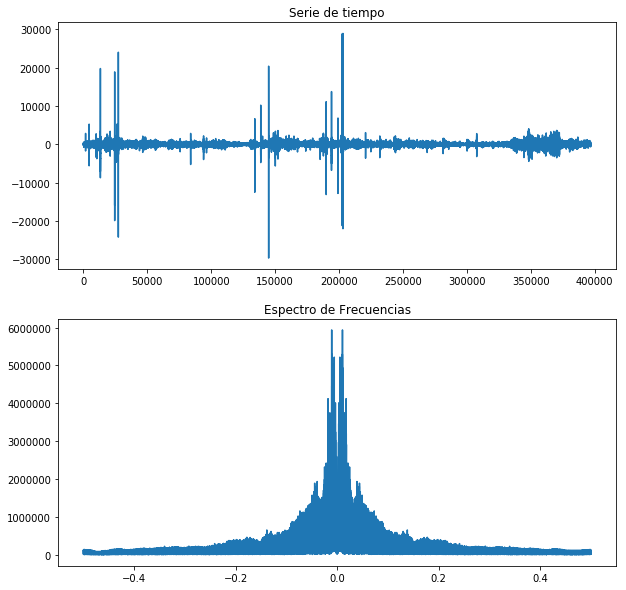

In [35]:
X_fourier = np.abs(np.fft.fft(X))
axs = range(396900)

freq = np.fft.fftfreq(396900)

plt.figure(figsize=(10,10))
plt.subplot(211)
plt.title("Serie de tiempo")
plt.plot(axs,X[0])
plt.subplot(212)
plt.title("Espectro de Frecuencias")
plt.plot(freq,X_fourier[0])
plt.show()


> **g) Para seguir con el pre-procesamiento realice un muestreo representativo de los datos a través de una técnica de muestreo especializada en secuencias ¿En qué beneficia este paso? ¿Cómo podrı́a determinar si el muestro es representativo?**

In [36]:
from scipy import signal
X_resampled = []
for i in range(X_fourier.shape[0]):
  sequence = X_fourier[i,:].copy()
  resampled_sequence = signal.resample(sequence,100000)
  X_resampled.append(resampled_sequence)
X_resampled = np.array(X_resampled)
X_resampled.shape

(176, 100000)

Este paso beneficia debido a que permite encontrar una representación de menor dimensión que mantenga las características del set de datos original.

Para comprobar si el muestreo es representativo se puede determinar si las dos representaciones de los datos se distribuyen de manera igual.

> **h) Debido a que no hay conjunto de pruebas, y que es necesario para evaluar la calidad final del modelo, genérelo a través de la técnica hold-out**

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_resampled, Y, test_size=0.25, random_state=42)

> **i) Realice un proceso de estándarizar los datos para ser trabajados adecuadamente. Recuerde que solo se debe ajustar (calcular media y desviación estándar) con el conjunto de entrenamiento.**

In [109]:
#Agregar nueva dimensión para más adelante
minimos_train = []
minimos_test = []
for i in X_train:
  minimos_train.append(min(i))
for i in X_test:
  minimos_test.append(min(i))
  
X2_train = np.c_[X_train,maximos_train]
X2_test = np.c_[X_test, maximos_test]

from sklearn.preprocessing import StandardScaler
std = StandardScaler(with_mean=True, with_std=True)
std.fit(X_train)
X_train = std.transform(X_train)
X_test = std.transform(X_test)

std = StandardScaler(with_mean = True, with_std=True)
std.fit(X2_train)
X2_train = std.transform(X2_train)
X2_test = std.transform(X2_test)

Se estandarizan los datos que actuarán como entrada del learner, utilizando la media y la distribución estándar. Este escalamiento funciona de gran manera si los datos se distribuyen normalmente. En caso contrario se podría usar Min-Max Scaler para llevar los datos a un rango $[0, 1]$, o si se cuenta con muchos outliers se podría usar Robust Scaler, el cual usa el rango intercuartílico para normalizar. 

> **j) Realice una reducción de dimensionalidad a través de la técnica PCA, para representar los datos en  $d=2$  dimensiones. Recuerde que solo se debe ajustar (encontrar las componentes principales) con el conjunto de entrenamiento. Visualice apropiadamente la proyección en 2 dimensiones.**

PCA es una técnica de reducción de dimensionalidad, el cual busca mantener la variabilidad original de los datos, por lo que busca maximizar la variabilidad de la proyección sujeto a que la norma de los vectores de la proyección se mantenga constante.

PCA utiliza los vectores propios de la matriz de covarianza asociados a los valores propios más altos (debido a que busca maximizar).

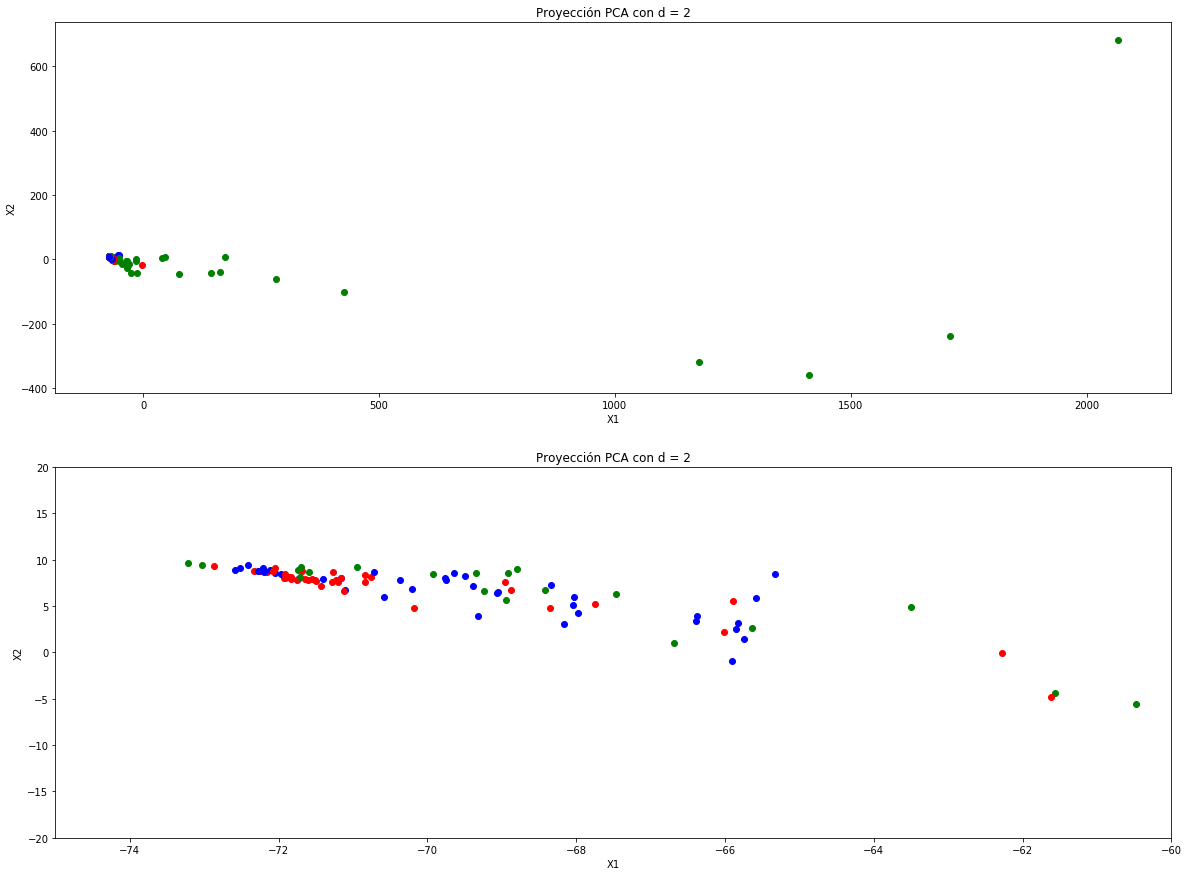

In [39]:
from sklearn.decomposition import PCA
d = 2
pca_model = PCA(n_components = d)
pca_model.fit(X_train)
X_pca_train = pca_model.transform(X_train)
X_pca_test = pca_model.transform(X_test)

plt.figure(figsize=(20,15))
plt.subplot(211)
for i in range(len(X_pca_train)):
  if Y_train[i]==0:
    plt.scatter(X_pca_train[i,0], X_pca_train[i,1], c="green")
  elif Y_train[i] ==1:
    plt.scatter(X_pca_train[i,0], X_pca_train[i,1], c="red")
  else:
    plt.scatter(X_pca_train[i,0], X_pca_train[i,1], c="blue")
    
plt.title("Proyección PCA con d = 2")
plt.xlabel("X1")
plt.ylabel("X2")
plt.subplot(212)
for i in range(len(X_pca_train)):
  if Y_train[i]==0:
    plt.scatter(X_pca_train[i,0], X_pca_train[i,1], c="green")
  elif Y_train[i] ==1:
    plt.scatter(X_pca_train[i,0], X_pca_train[i,1], c="red")
  else:
    plt.scatter(X_pca_train[i,0], X_pca_train[i,1], c="blue")
    
plt.title("Proyección PCA con d = 2")
plt.xlabel("X1")
plt.ylabel("X2")
plt.axis([-75,-60,-20,20])
plt.show()

Se grafica la proyección realizada por PCA, se observa que los datos están muy concentrados en torno al $[-75, -60]$ por lo que se realiza un zoom en esta zona. Se observa que las diferentes clases están muy juntas, esto debido a que PCA no toma en cuenta que los datos tienen distintas clases, por lo que no utiliza esta información.

> **k) Entrene un modelo de Regresión Logı́stica variando el parámetro de regularización  $C$  construyendo un gráfico resumen del error en función de este hiper-parámetro. Además entrene un Perceptrón, variando el hiper-parámetro de regularización  $\alpha$  en el rango inverso que para la Regresión Logı́stica ¿Por qué? Contruya el mismo gráfico resumen, en función de  $C$  o  $\alpha$ . Compare y comente lo observado.**

In [40]:
from sklearn.metrics import accuracy_score

Cs = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
alphas = [1/c for c in Cs]

logisticTrainError = []
logisticTestError = []
perceptronTrainError = []
perceptronTestError = []

from sklearn.linear_model import Perceptron, LogisticRegression

for i in range(len(Cs)):
  #Instanciación de los modelos
  logisticModel = LogisticRegression(penalty='l2', C=Cs[i], max_iter=200)
  perceptronModel = Perceptron(penalty='l2', alpha=alphas[i], max_iter=200)
  
  #Entrenamiento
  logisticModel.fit(X_pca_train,Y_train)
  perceptronModel.fit(X_pca_train,Y_train)
  
  #Predicciones
  #Training
  logisticTrainPredict = logisticModel.predict(X_pca_train)
  perceptronTrainPredict = perceptronModel.predict(X_pca_train)
  #Testing
  logisticTestPredict = logisticModel.predict(X_pca_test)
  perceptronTestPredict = perceptronModel.predict(X_pca_test)
  
  #Calculo y almacenamiento del error
  
  #Training
  logisticTrainError.append(1 - accuracy_score(Y_train, logisticTrainPredict))
  perceptronTrainError.append(1 - accuracy_score(Y_train, perceptronTrainPredict))
  
  #Testing
  logisticTestError.append(1 - accuracy_score(Y_test, logisticTestPredict))
  perceptronTestError.append(1 - accuracy_score(Y_test, perceptronTestPredict))
  
  

 

El motivo por el cual es necesario obtener la inversa de C para obtener $\alpha$ viene dado por la forma en que se implemento el algoritmo en la libreria sklearn. El parametro C en la regresión logistica se define como la inversa del parametro de regularización, el cual mientras más pequeño significa una mayor regularización. Por otro lado, el parametro $\alpha$ se define como el parámetro que multiplica a la regularización, por lo que a mayor valor, mayor regularización.

De esta forma se obtiene la misma fuerza de regularización para ambos modelos.

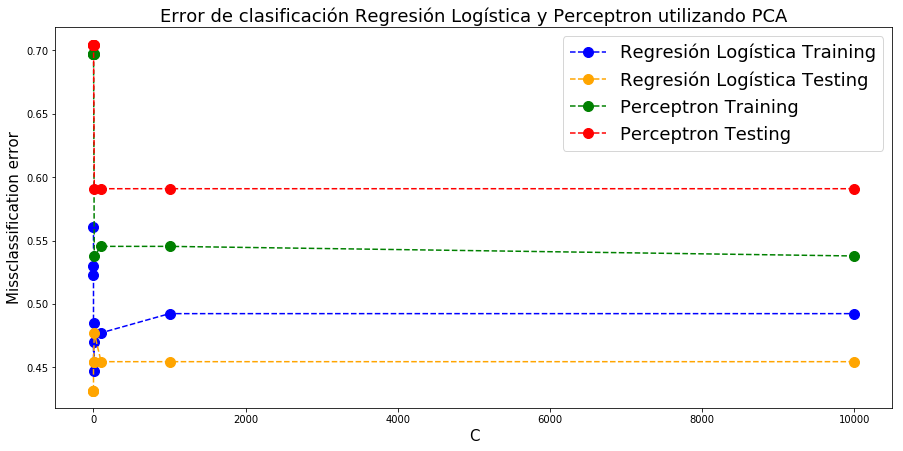

Error de testing Regresor Logístico: 0.446969696969697
Parámetro utilizado: 1
Error de testing Perceptron: 0.5378787878787878
Parámetro utilizado: 0.1


In [41]:
plt.figure(figsize=(15,7))
plt.title("Error de clasificación Regresión Logística y Perceptron utilizando PCA",fontsize=18)
plt.plot(Cs, logisticTrainError,".--", color="blue", markersize=20)
plt.plot(Cs, logisticTestError,".--", color="orange",markersize=20)
plt.plot(Cs, perceptronTrainError,".--", color="green", markersize=20)
plt.plot(Cs, perceptronTestError,".--",color="red",markersize=20)
plt.xlabel("C",fontsize=15)
plt.ylabel("Missclassification error",fontsize=15)
plt.legend(["Regresión Logística Training","Regresión Logística Testing","Perceptron Training","Perceptron Testing"], prop={'size':18})
plt.show() 

print("Error de testing Regresor Logístico: " + str(min(logisticTrainError)))
print("Parámetro utilizado: " + str(Cs[logisticTrainError.index(min(logisticTrainError))]))
print("Error de testing Perceptron: "+ str(min(perceptronTrainError)))
print("Parámetro utilizado: " + str(1/Cs[perceptronTrainError.index(min(perceptronTrainError))]))

  


Existen distintos comportamientos al analizar la forma de los gráficos, para mejor interpretación, a medida que aumenta la magnitud de C, el factor de regularización disminuye. Para el conjunto de testing del perceptrón se puede ver un aumento en los errores de clasificación en las primeras iteraciones para luego disminuir. La regresión logistica por su parte, aumenta su error de clasificación para luego mantenerse constante en el resto de los entrenamientos.

Al comparar el desempeño en el conjunto de testing se puede ver un desempeño constante en la regresión logistica (a excepción de los primeros valores, donde aparece con un mal desempeño) para diferentes factores de regularización, mientras que el perceptron aumenta su desempeño en las primeras iteraciones para luego disminuir monotonamente, esto puede deberse a que el perceptron trabaja con hiperplanos para realizar las clasificaciones.

Se asume, debido a la evidencia gráficada que la regresión logistica presenta un mejor desempeño que el perceptron.



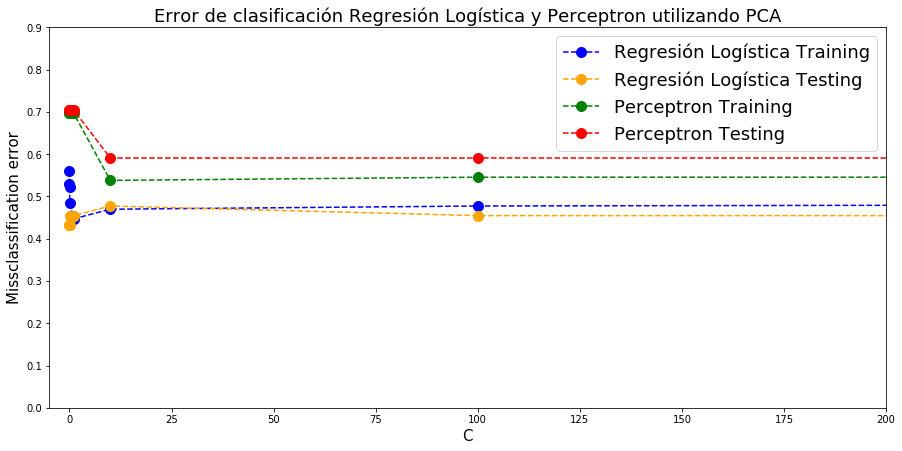

In [42]:
plt.figure(figsize=(15,7))
plt.title("Error de clasificación Regresión Logística y Perceptron utilizando PCA",fontsize=18)
plt.plot(Cs, logisticTrainError,".--", color="blue", markersize=20)
plt.plot(Cs, logisticTestError,".--", color="orange",markersize=20)
plt.plot(Cs, perceptronTrainError,".--", color="green", markersize=20)
plt.plot(Cs, perceptronTestError,".--",color="red",markersize=20)
plt.xlabel("C",fontsize=15)
plt.ylabel("Missclassification error",fontsize=15)
plt.legend(["Regresión Logística Training","Regresión Logística Testing","Perceptron Training","Perceptron Testing"], prop={'size':18})
plt.axis([-5,200,0,0.9])
plt.show() 



Se observa la misma situación anterior. A medida que aumenta el parámetro de regularización $C$ ($\alpha^{-1}$) se disminuye el error de training y aumenta el error de testing, lo que concuerda al considerar que a medida que $\alpha$ aumenta aumenta el error de entrenamiento (asociado a la verosimilitud) y disminuye el error testing. Como el error de training no es buen factor para elegir un posible parámetro de regularización, se utilizará el error de testing, encontrando así que el mejor parámetro para este caso es $C = \alpha = 1$.

> **l) Genere otra representación de los datos a través de la técnica de reducción de dimensionalidad ICA, con dimensionalidad  $d = 2$ . Recuerde que sólo se debe ajustar con el conjunto de entrenamiento, si se muestra un warning explique el porqué. Visualice apropiadamente la proyección en 2 dimensiones. Vuelva a realizar el item k) pero para esta nueva representación.**

ICA es una generalización de PCA, el cual asume que los datos son independientes, por lo que busca que los datos con dimensionalidad reducida sean independientes. Por lo que busca la varianza máxima bajo este criterio.

In [43]:
from sklearn.decomposition import FastICA
ica_model = FastICA(n_components=d)
ica_model.fit(X_train)
X_ica_train = ica_model.transform(X_train)
X_ica_test = ica_model.transform(X_test)

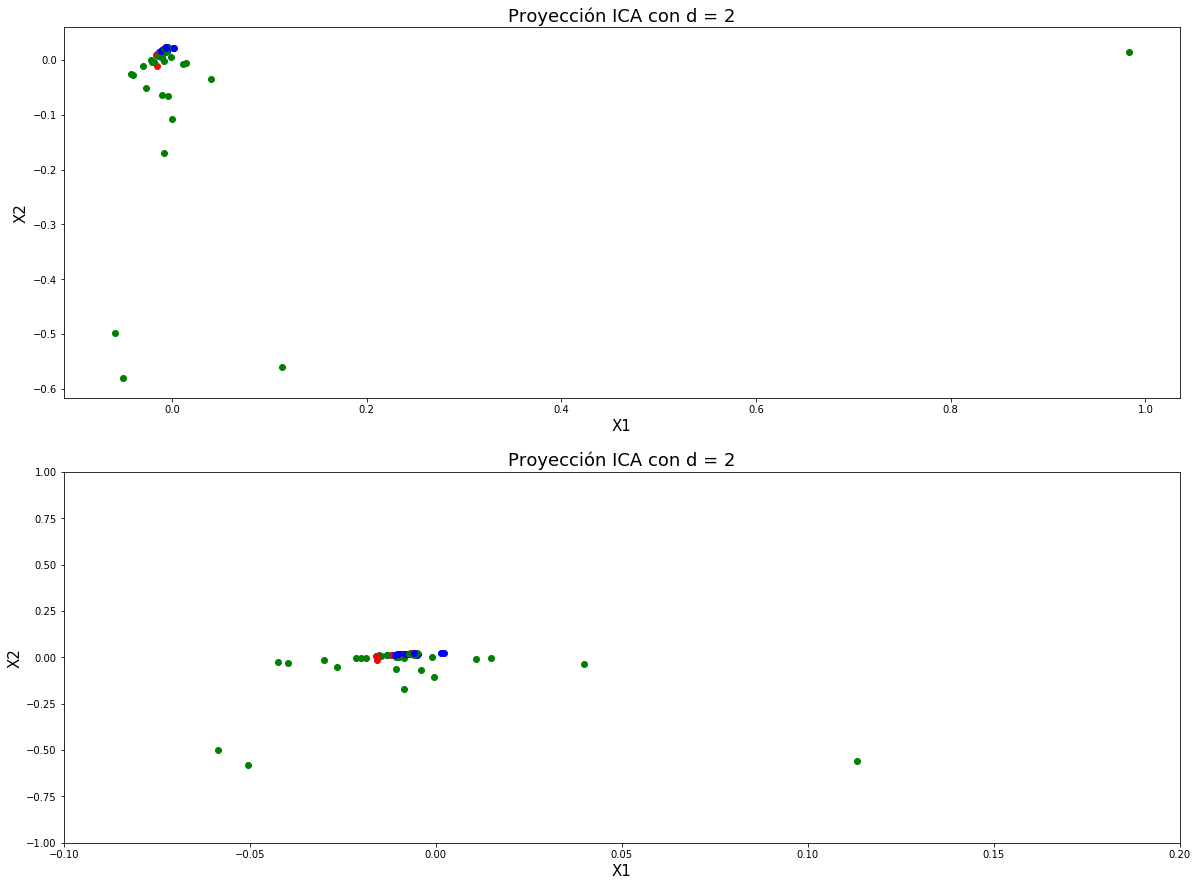

In [44]:
plt.figure(figsize=(20,15))
plt.subplot(211)
for i in range(len(X_ica_train)):
  if Y_train[i]==0:
    plt.scatter(X_ica_train[i,0], X_ica_train[i,1], c="green")
  elif Y_train[i] ==1:
    plt.scatter(X_ica_train[i,0], X_ica_train[i,1], c="red")
  else:
    plt.scatter(X_ica_train[i,0], X_ica_train[i,1], c="blue")
    
plt.title("Proyección ICA con d = 2", fontsize=18)
plt.xlabel("X1",fontsize=15)
plt.ylabel("X2",fontsize=15)
plt.subplot(212)
for i in range(len(X_ica_train)):
  if Y_train[i]==0:
    plt.scatter(X_ica_train[i,0], X_ica_train[i,1], c="green")
  elif Y_train[i] ==1:
    plt.scatter(X_ica_train[i,0], X_ica_train[i,1], c="red")
  else:
    plt.scatter(X_ica_train[i,0], X_ica_train[i,1], c="blue")
    
plt.title("Proyección ICA con d = 2", fontsize=18)
plt.xlabel("X1",fontsize=15)
plt.ylabel("X2",fontsize=15)
plt.axis([-0.1,0.2,-1,1])
plt.show()

Nuevamente se observan que los datos de la proyección estan muy juntos entre sí, por lo que el problema de clasificar puede llegar a ser muy tedioso en caso de utilizar planos separadores.

In [45]:

from sklearn.linear_model import Perceptron, LogisticRegression

def getMissClassError(Xtrain, Xtest):
  lTrainError = []
  lTestError = []
  pTrainError = []
  pTestError = []

  for i in range(len(Cs)):
    #Instanciación de los modelos
    logisticModel = LogisticRegression(penalty='l2', C=Cs[i], max_iter=200)
    perceptronModel = Perceptron(penalty='l2', alpha=alphas[i], max_iter=200)

    #Entrenamiento
    logisticModel.fit(Xtrain,Y_train)
    perceptronModel.fit(Xtrain,Y_train)

    #Predicciones
    #Training
    logisticTrainPredict = logisticModel.predict(Xtrain)
    perceptronTrainPredict = perceptronModel.predict(Xtrain)
    #Testing
    logisticTestPredict = logisticModel.predict(Xtest)
    perceptronTestPredict = perceptronModel.predict(Xtest)

    #Calculo y almacenamiento del error

    #Training
    lTrainError.append(1 - accuracy_score(Y_train, logisticTrainPredict))
    pTrainError.append(1 - accuracy_score(Y_train, perceptronTrainPredict))

    #Testing
    lTestError.append(1 - accuracy_score(Y_test, logisticTestPredict))
    pTestError.append(1 - accuracy_score(Y_test, perceptronTestPredict))
  
  return lTrainError, lTestError, pTrainError, pTestError
  
logisticTrainError, logisticTestError, perceptronTrainError, perceptronTestError = getMissClassError(X_ica_train, X_ica_test)

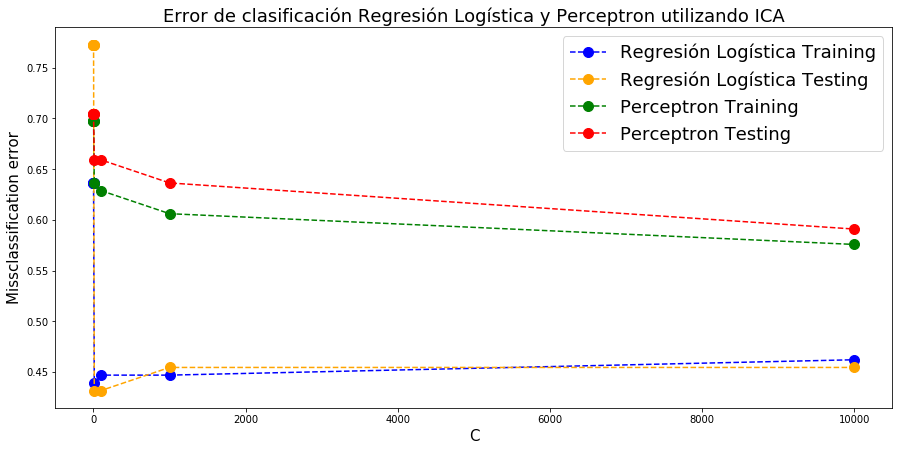

Error de testing Regresor Logístico: 0.43939393939393945
Parámetro utilizado: 10
Error de testing Perceptron: 0.5757575757575757
Parámetro utilizado: 0.0001


In [46]:
plt.figure(figsize=(15,7))
plt.title("Error de clasificación Regresión Logística y Perceptron utilizando ICA",fontsize=18)
plt.plot(Cs, logisticTrainError,".--", color="blue", markersize=20)
plt.plot(Cs, logisticTestError,".--", color="orange",markersize=20)
plt.plot(Cs, perceptronTrainError,".--", color="green", markersize=20)
plt.plot(Cs, perceptronTestError,".--",color="red",markersize=20)
plt.xlabel("C",fontsize=15)
plt.ylabel("Missclassification error",fontsize=15)
plt.legend(["Regresión Logística Training","Regresión Logística Testing","Perceptron Training","Perceptron Testing"], prop={'size':18})
plt.show() 

print("Error de testing Regresor Logístico: " + str(min(logisticTrainError)))
print("Parámetro utilizado: " + str(Cs[logisticTrainError.index(min(logisticTrainError))]))
print("Error de testing Perceptron: "+ str(min(perceptronTrainError)))
print("Parámetro utilizado: " + str(1/Cs[perceptronTrainError.index(min(perceptronTrainError))]))

Se observa la misma situación anterior (caso PCA), donde el Regresor Logístico obtiene mejores resultados que el Perceptrón. En este caso, para el Perceptrón, los errores de training y testing se comportan de manera similar al variar el parámetro de regularización. 

Se realiza un zoom en la zona entre 0 y 200 para el parámetro de regularización para observar de mejor manera lo que ocurre en dicho sector.

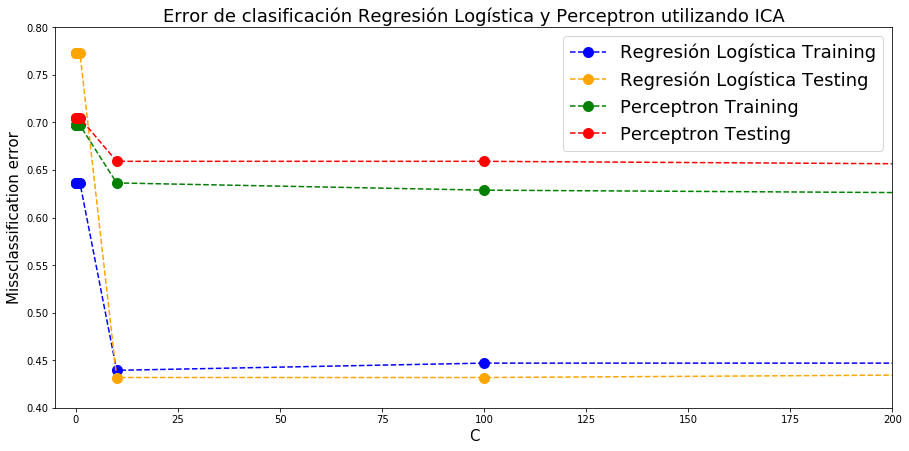

In [47]:
plt.figure(figsize=(15,7))
plt.title("Error de clasificación Regresión Logística y Perceptron utilizando ICA",fontsize=18)
plt.plot(Cs, logisticTrainError,".--", color="blue", markersize=20)
plt.plot(Cs, logisticTestError,".--", color="orange",markersize=20)
plt.plot(Cs, perceptronTrainError,".--", color="green", markersize=20)
plt.plot(Cs, perceptronTestError,".--",color="red",markersize=20)
plt.xlabel("C",fontsize=15)
plt.ylabel("Missclassification error",fontsize=15)
plt.legend(["Regresión Logística Training","Regresión Logística Testing","Perceptron Training","Perceptron Testing"], prop={'size':18})
plt.axis([-5,200,0.4,0.8])
plt.show()

Nuevamente se observa la misma situación producida en el caso PCA, lo cual es lo esperado dada la técnica de regularización ($l_2$) utilizada. En este caso el mejor parámetro para esta situación es $C = \alpha^{-1} = 10$.

> **m) Experimente con diferentes dimensiones  $d$  para la proyección de PCA e ICA con el propósito de obtener un modelo con menor error. Construya una tabla o gráfico resumen de los errores o accuracy, comente.**

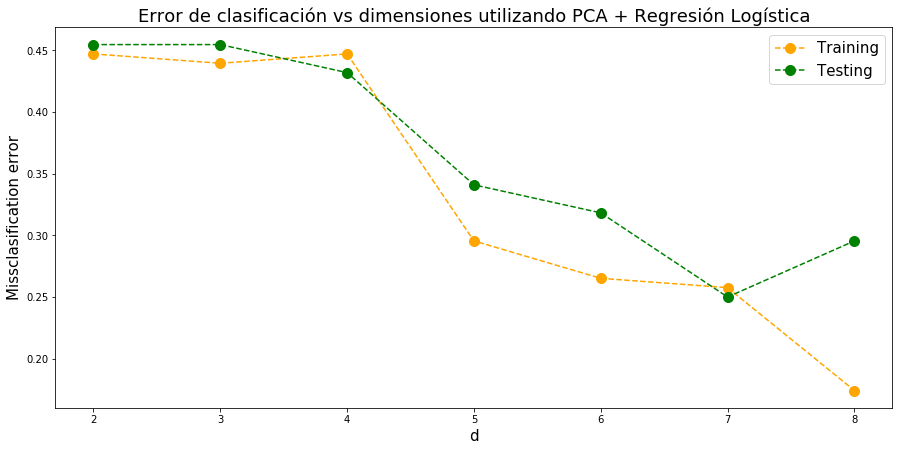

Error de testing mínimo: 0.25
Dimensiones utilizadas: 7


In [48]:
d = [2, 3, 4, 5, 6, 7, 8]
def dPCAlogistic():
  trainingError = []
  testingError = []
  for i in d:
    # Aplicar PCA
    pca_model = PCA(n_components=i)
    pca_model = pca_model.fit(X_train)
    X_pca_train = pca_model.transform(X_train)
    X_pca_test = pca_model.transform(X_test)
    # Generar el Modelo
    logisticModel = LogisticRegression(penalty='l2', C=1, max_iter=200)
    # Entrenar el Modelo
    logisticModel.fit(X_pca_train, Y_train)
    # Calculo de predicciones
    y_trainPredict = logisticModel.predict(X_pca_train)
    y_testPredict = logisticModel.predict(X_pca_test)
    # Calculo error de clasificacion
    trainingError.append(1 - accuracy_score(Y_train, y_trainPredict))
    testingError.append(1 - accuracy_score(Y_test,y_testPredict))
  return trainingError, testingError


train, test = dPCAlogistic()


plt.figure(figsize=(15,7))
plt.title("Error de clasificación vs dimensiones utilizando PCA + Regresión Logística", fontsize=18)
plt.xlabel("d",fontsize=15)
plt.ylabel("Missclasification error", fontsize=15)
plt.plot(d, train,".--", color="orange", markersize=20)
plt.plot(d, test,".--",color="green", markersize=20)
plt.legend(["Training", "Testing"], prop={'size':15})
plt.show()


print("Error de testing mínimo: " + str(min(test)))
print("Dimensiones utilizadas: " + str(d[test.index(min(test))]))


Se observa a medida que se aumentan las dimensiones, empezando desde $d = 2$, como disminuye el error de entrenamiento y de pruebas. 

Al momento de llegar a $d = 7$ se obtiene el mínimo valor para ambos errores. Luego, al aumentar las dimensiones comienza a aumentar el error de testing mientras disminuye el error de training, lo que indica presencia de overfitting.  

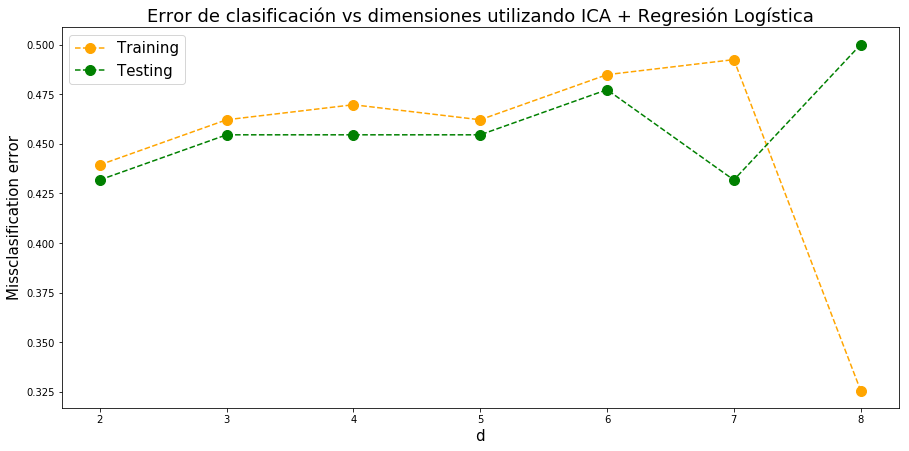

Error de testing mínimo: 0.43181818181818177
Dimensiones utilizadas: 2


In [49]:
def dICAlogistic():
  trainingError = []
  testingError = []
  for i in d:
    # Aplicar ICA
    ica_model = FastICA(n_components=i)
    ica_model = ica_model.fit(X_train)
    X_ica_train = ica_model.transform(X_train)
    X_ica_test = ica_model.transform(X_test)
    # Generar el Modelo
    logisticModel = LogisticRegression(penalty='l2', C=10, max_iter=200)
    # Entrenar el Modelo
    logisticModel.fit(X_ica_train, Y_train)
    # Calculo de predicciones
    y_trainPredict = logisticModel.predict(X_ica_train)
    y_testPredict = logisticModel.predict(X_ica_test)
    # Calculo error de clasificacion
    trainingError.append(1 - accuracy_score(Y_train, y_trainPredict))
    testingError.append(1 - accuracy_score(Y_test,y_testPredict))
  return trainingError, testingError


train2, test2 = dICAlogistic()


plt.figure(figsize=(15,7))
plt.title("Error de clasificación vs dimensiones utilizando ICA + Regresión Logística", fontsize=18)
plt.xlabel("d",fontsize=15)
plt.ylabel("Missclasification error", fontsize=15)
plt.plot(d, train2,".--", color="orange", markersize=20)
plt.plot(d, test2,".--",color="green", markersize=20)
plt.legend(["Training", "Testing"], prop={'size':15})
plt.show()


print("Error de testing mínimo: " + str(min(test2)))
print("Dimensiones utilizadas: " + str(d[test2.index(min(test2))]))

En el caso de ICA, el valor mínimo se alcanza con 2 dimensiones, donde al agregar dimensiones aumentan ambos errores. 

Nuevamente con $d = 7$ se observa un punto de quiebre, donde al aumentar las dimensiones se produce overfitting.

> **n) Realice otra reducción de dimensionalidad ahora a través de la técnica LDA, para representar los datos en  $d=2$  dimensiones. Recuerde que sólo se debe ajustar con el conjunto de entrenamiento, si se muestra un warning explique el porqué. Visualice apropiadamente la proyección en 2 dimensiones.**

En este caso se utiliza LDA para reducir la dimensionalidad. Cabe destacar que esta técnica si es conciente de la clase de los datos, por lo que intenta maximizar la varianza inter-clases manteniendo fija la intra-clase, de esta manera es posible encontrar una proyección conciente de la clase del dato.

In [50]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
#Instanciación LDA con 2 componentes
lda_model = LDA(n_components=2)
#Ajuste del modelo
lda_model.fit(X_train,Y_train)
#Descenso dimensionaaaaal
X_lda_train = lda_model.transform(X_train)
X_lda_test = lda_model.transform(X_test)

#WARNING Variables son Collinear <--- explicar

/home/andres/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Se produce un warning debido a que existen variables colineares, es decir, que existe una dependencia lineal entre ellas. Esto es malo para la técnica LDA, debido a que utiliza inversas de matrices, lo cual no es posible si la matriz tiene determinante 0, que es lo que sucede cuando se tienen dependencias lineales entre atributos.

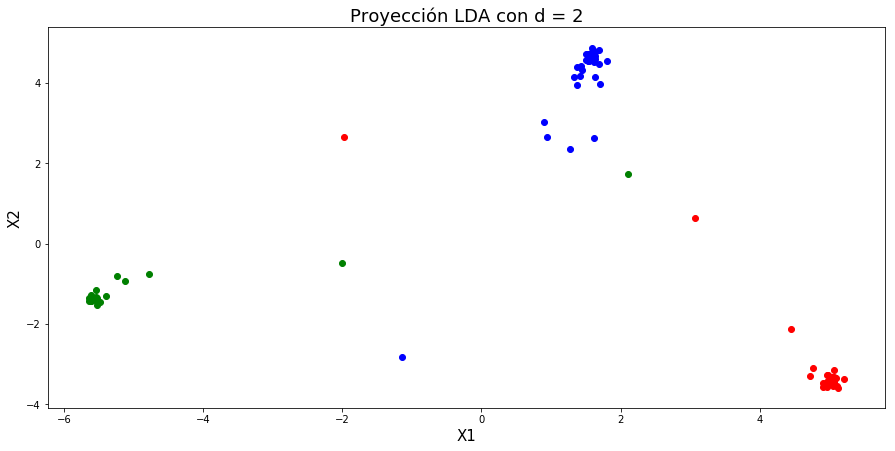

In [51]:
plt.figure(figsize=(15,7))
for i in range(len(X_lda_train)):
  if Y_train[i]==0:
    plt.scatter(X_lda_train[i,0], X_lda_train[i,1], c="green")
  elif Y_train[i] ==1:
    plt.scatter(X_lda_train[i,0], X_lda_train[i,1], c="red")
  else:
    plt.scatter(X_lda_train[i,0], X_lda_train[i,1], c="blue")
    
plt.title("Proyección LDA con d = 2", fontsize=18)
plt.xlabel("X1",fontsize=15)
plt.ylabel("X2",fontsize=15)
plt.show()

Como se mencionó anteriormente, LDA es conciente de la clase de los datos, por lo que la proyección de estos mantiene los conjuntos de clases más separados unos de otros. Esto es de mucha utilidad al momento de utilizar planos separadores, pues la diferencia entre clases es más evidente.

También se pueden observar que hay datos muy separados de sus pares de clase, lo que podría traer problemas en el entrenamiento.

> **o) Con el propósito de encontrar el mejor modelo vuelva a realizar el item k) en el nuevo espacio generado por la representación según las  $d$  dimensiones de la proyección LDA. Esta nueva representación ¿mejora o empeora el desempeño? Explique.**

In [52]:
logisticTrainError, logisticTestError, perceptronTrainError, perceptronTestError = getMissClassError(X_lda_train, X_lda_test)

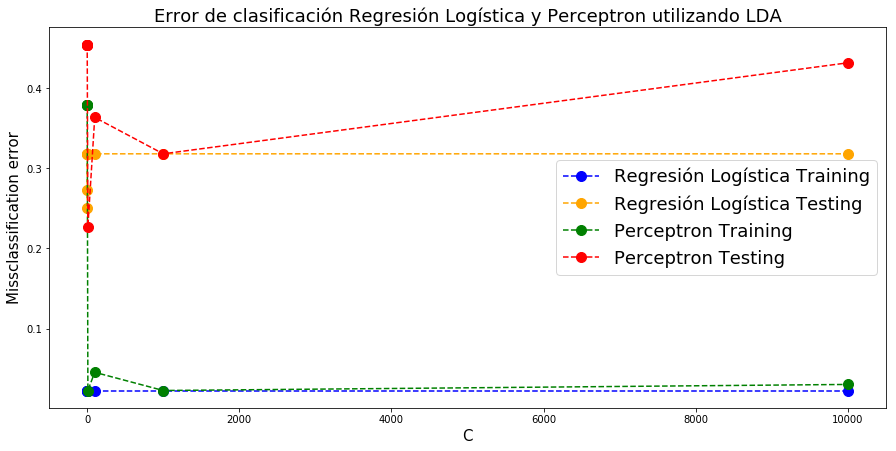

Error mínimo Regresor Logístico testing: 0.25
Parámetro Utilizado: 0.0001
Error mínimo Perceptron testing: 0.2272727272727273
Parámetro Utilizado: 0.1


In [53]:
plt.figure(figsize=(15,7))
plt.title("Error de clasificación Regresión Logística y Perceptron utilizando LDA",fontsize=18)
plt.plot(Cs, logisticTrainError,".--", color="blue", markersize=20)
plt.plot(Cs, logisticTestError,".--", color="orange",markersize=20)
plt.plot(Cs, perceptronTrainError,".--", color="green", markersize=20)
plt.plot(Cs, perceptronTestError,".--",color="red",markersize=20)
plt.xlabel("C",fontsize=15)
plt.ylabel("Missclassification error",fontsize=15)
plt.legend(["Regresión Logística Training","Regresión Logística Testing","Perceptron Training","Perceptron Testing"], prop={'size':18})
plt.show() 


print("Error mínimo Regresor Logístico testing: " + str(min(logisticTestError)))
print("Parámetro Utilizado: " + str(Cs[logisticTestError.index(min(logisticTestError))]))
print("Error mínimo Perceptron testing: " + str(min(perceptronTestError)))
print("Parámetro Utilizado: " + str(1/Cs[perceptronTestError.index(min(perceptronTestError))]))

Se obtiene un error de testing de 0.25 para el Regresor logístico, lo cual iguala a los resultados obtenidos con PCA, por lo que la representación de los datos de entrada es igual de útil. 

> **p) Intente mejorar el desempeño de los algoritmos ya entrenados. Diseñe ahora sus propias caracteristicas (feature crafting) a partir de los datos brutos (secuencia de amplitudes), puede inspirarse en otros trabajos si desea.**

Para mejorar el desempeño se decide agregar una característica a la matriz de entrada de una regresión logística, el cual es la frecuencia mínima presente en los datos después de realizar el muestreo representativo.

Esto se realiza pues el experto [1] menciona que los corazones de la clases _**murmur**_ poseen sonidos de frecuencias bajas, por lo que una frecuencia mínima de menor valor con respecto a los otros datos indicará que estamos en presencia de dicha clase.

Esta nuevo atributo se agrega después de realizar un descenso dimensional utilizando LDA, para aprovechar la separación entre clases que se obtiene al utilizar este modelo.

Se utiliza regresión logística con penalización con norma $l_2$ con un parámetro $C = 0.0001$ puesto que es el modelo con el que se obtuvo mejores resultados.

In [110]:
#from sklearn.decomposition import KernelPCA as KPCA
def dLDAlogistic():
  trainingError = []
  testingError = []
  lda_model = LDA(n_components=2)
  lda_model = lda_model.fit(X_train, Y_train)
  X_lda_train = lda_model.transform(X_train)
  X_lda_test = lda_model.transform(X_test)
  
  X_lda_train = np.c_[X_lda_train, minimos_train]
  X_lda_test = np.c_[X_lda_test, minimos_test]
  
  # Generar el Modelo
  logisticModel = LogisticRegression(penalty='l2', C=0.0001, max_iter=200)
  # Entrenar el Modelo
  logisticModel.fit(X_lda_train, Y_train)
  # Calculo de predicciones
  y_trainPredict = logisticModel.predict(X_lda_train)
  y_testPredict = logisticModel.predict(X_lda_test)
  # Calculo error de clasificacion
  trainingError.append(1 - accuracy_score(Y_train, y_trainPredict))
  testingError.append(1 - accuracy_score(Y_test,y_testPredict))
  
  return trainingError, testingError

trainDLDA, testDLDA = dLDAlogistic() 

In [111]:

print("Error de testing mínimo: " + str(min(testDLDA)))
print(trainDLDA)
print(testDLDA)

Error de testing mínimo: 0.2272727272727273
[0.022727272727272707]
[0.2272727272727273]


Al usar esta nueva característica el error de testing disminuye de 0.25 a 0.22 aproximadamente, por lo que el agregar esta nueva característica fue de ayuda para mejorar las predicciones.

# Análisis de emociones en *tweets*
<hr style="height:2px;border:none"/>


> **a) Construya un dataframe con los datos a analizar. Determine cuántas clases existen, cuántos registros por clase y describa el dataset.**

           tweet_id
count  4.000000e+04
mean   1.845184e+09
std    1.188579e+08
min    1.693956e+09
25%    1.751431e+09
50%    1.855443e+09
75%    1.962781e+09
max    1.966441e+09
(40000, 4)
     tweet_id   sentiment       author  \
0  1956967341       empty   xoshayzers   
1  1956967666     sadness    wannamama   
2  1956967696     sadness    coolfunky   
3  1956967789  enthusiasm  czareaquino   
4  1956968416     neutral    xkilljoyx   

                                             content  
0  @tiffanylue i know  i was listenin to bad habi...  
1  Layin n bed with a headache  ughhhh...waitin o...  
2                Funeral ceremony...gloomy friday...  
3               wants to hang out with friends SOON!  
4  @dannycastillo We want to trade with someone w...  
tweet_id     40000
sentiment       13
author       33871
content      39827
dtype: int64


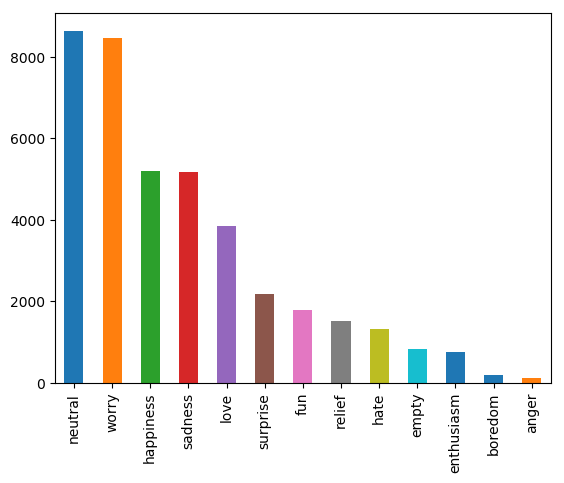

MissxMarisa       23
ChineseLearn      22
MiDesfileNegro    19
erkagarcia        19
lost_dog          18
Name: author, dtype: int64
neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64


In [56]:
import pandas as pd
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")

df3 = pd.read_csv('emotionanalysis/text_emotion.csv')

print(df3.describe())
print(df3.shape)
print(df3.head())
print(df3.nunique())

df3['sentiment'].value_counts().plot(kind='bar')
plt.show()

print(df3['author'].value_counts().head())
print(df3['sentiment'].value_counts())


Existen un total de 40000 registros distintos en el dataset de los cuales cada uno posee un texto de contenido el cual puede ser catalogado como un sentimiento o emoción, del total se diferencian **13 distintos sentimientos** los cuales se componen como **neutral, preocupado, felicidad, tristesa, amor, sorpresa, divertido, aliviado, odio, vacío, entusiasta, aburrido y enojado**. Cada clase posee la siguiente cantidad de registros:

- Neutral: 8638
- Preocupado: 8459
- Felicidad: 5209
- Tristesa: 5165
- Amor: 3842
- Sorpresa: 2187
- Divertido: 1776
- Aliviado: 1526
- Odio: 1323
- Vacío: 827
- Entusiasta: 759
- Aburrido: 179
- Enojado: 110

La gran mayoria de mensajes publicados son distintos entre si. Existen un total de 33871 autores. Ademas, la mayor cantidad de twits corresponden a mensajes con sentimientos de **neutral o preocupado**, mientras que la clase con menor cantidad de twits corresponde a **entusiasta y enojado**

> ** b) Construya un conjunto de entrenamiento y otro de pruebas, a través de una máscara aleatoria, para verificar los resultados de los algoritmos. Genere un conjunto de validación si estima conveniente.**

In [57]:
import numpy as np

np.random.seed(70)
msk = np.random.rand(len(df3)) < 0.8
#Se crean las mascaras de entrenamiento y testing
df3_train = df3[msk]
df3_test = df3[~msk]

Se extrae la columna de contenido de cada twit para su posterior procesamiento, por otro lado se extraen los labels correspondiente a cada mensaje.

> **c) Construya las representaciones de los datos con los que trabajará, ya sea para las entradas de los modelos como para las salidas. Recuerde que tendrá que codificar las distintas clases como valores numéricos enteros. **

In [58]:
text_train = df3_train.content
sentiment_train = df3_train.sentiment
text_test = df3_test.content
sentiment_test = df3_test.sentiment

In [59]:
from sklearn import preprocessing

#Se crea un preprocesador para convertir los labels en valores numericos
le = preprocessing.LabelEncoder()
le.fit(np.asarray(df3_train.sentiment))
le.classes_
le.transform(np.asarray(df3_train.sentiment))

#Se guardan los labels que se le otorgan a cada clase
labs = le.transform(['neutral', 'worry', 'happiness', 'sadness', 'love', 'surprise', 'fun', 'relief', 'hate', 'empty', 'enthusiasm', 'boredom', 'anger'])

Para entrenar la maquina es necesario que los mensajes esten normalizados, por lo que se extraen palabras que puedan repetirse mucho conocidas como stopwords, se utilizan las Stopwords de la biblioteca nltk y de sklearn.

In [60]:
import re, time, nltk

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from sklearn.feature_extraction import stop_words
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer, word_tokenize
from nltk.stem.porter import PorterStemmer


def word_extractor1(text):
    wordlemmatizer = WordNetLemmatizer()
    commonwords = stopwords.words('english')
    commonwords2 = stop_words.ENGLISH_STOP_WORDS
    text = re.sub(r'([a-z])\1+', r'\1\1',text)#substitute multiple letter by two
    text = text.replace('[^\w\s]',' ')
    #text = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",text)
    words = ""
    wordtokens = [ wordlemmatizer.lemmatize(word.lower())for word in word_tokenize(text) ]
    for word in wordtokens:
        if word not in (commonwords or commonwords2):
            words+=" "+word
    return words


[nltk_data] Error loading stopwords: <urlopen error [Errno -2] Name or
[nltk_data]     service not known>
[nltk_data] Downloading package punkt to /home/andres/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/andres/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Se utiliza un CountVectorizer para contar la cantidad de repeticiones de cada palabra en un twit.

In [61]:
from sklearn.feature_extraction.text import CountVectorizer

#Se procesan los mensajes para eliminar stopwords
texts_train = [word_extractor1(text) for text in text_train]
texts_test = [word_extractor1(text) for text in text_test]

#Se genera un CountVectorizer, ademas se deja como condición que una palabra 
#debe repetirse un minimo de 50 veces para que aparesca en el diccionario de palabras
vectorizer1 = CountVectorizer(min_df=50) 

features_train = vectorizer1.fit_transform(texts_train)
features_test = vectorizer1.transform(texts_test)

labels_train = le.transform(np.asarray(sentiment_train))
labels_test = le.transform(np.asarray(sentiment_test))

> **d) Entrene y compare al menos 4 de los diferentes clasificadores vistos en clases para clasificación (por ejemplo: Navie Bayes, Multinomial Naive Bayes, LDA, QDA, Regresión logı́stica y Perceptrón). Recuerde que algunos son extendidos por defecto a múltiples clases para detectar emociones en cada *tweet*, sin embargo, otros deben ser extentidos a través de otras técnicas, tal como *One vs One* y *One vs All/Rest*. Muestre tabla o gráfico resumen.**

De acuerdo a los datos entregados en el punto a) es muy probable que el learner no sea capaz de obtener buenos valores para clases del estilo **odio, vacío, entusiasta, aburrido y enojado**, esto se debe principalmente a que su frecuencia de aparición en comparación a los otros estados es muy baja, por lo que muy probablemente la máquina se vera inclinada a predecir valores de otro tipo.

<font size="5"> **Gaussian Naive Bayes** </font>

In [62]:
from sklearn.naive_bayes import GaussianNB

def do_GNaiveB(X_train, Y_train):
  model = GaussianNB()
  model = model.fit(X_train.todense(), Y_train)
  return model

<font size="5">** Bernoulli Naive Bayes **</font>

In [63]:
from sklearn.naive_bayes import BernoulliNB

def do_BNaiveB(X_train, Y_train):
  model = BernoulliNB()
  model = model.fit(X_train, Y_train)
  return model

<font size="5">** Multinomial Naive Bayes** </font>

In [64]:
from sklearn.naive_bayes import MultinomialNB

from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OutputCodeClassifier

def do_MNaiveB(X_train, Y_train, mult="ovr", classifiers=13):
  model = MultinomialNB()
  if mult == "ovo":
    model = OneVsOneClassifier(model)
    model = model.fit(X_train, Y_train)
  elif mult == "ecoc":
    model = OutputCodeClassifier(model, code_size=classifiers, random_state=0)
    model = model.fit(X_train.todense(), Y_train)
  else:
    model = model.fit(X_train, Y_train)
  return model

<font size="5"> **Logistic Regression **</font>

In [65]:
from sklearn.linear_model import LogisticRegression

def do_LOGIT(X_train, Y_train, mclass='multinomial', Cr=1.0, solv='newton-cg', penal='l2'):
    model = LogisticRegression(multi_class=mclass, solver=solv, C=Cr, max_iter=1000, penalty=penal) #'multinomial' 'ovr'  & 'newton-cg' or 'lbfgs'
    model = model.fit(X_train, Y_train)
    return model

<font size="5"> ** Quadratic Discriminant Analysis** </font>

In [66]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

def do_QDA(X_train, Y_train):
  model = QuadraticDiscriminantAnalysis()
  model = model.fit(X_train.todense(), Y_train)
  return model

<font size="5">** Linear Discriminant Analysis **</font>

In [67]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

def do_LDA(X_train, Y_train):
  model = LinearDiscriminantAnalysis()
  model = model.fit(X_train.todense(), Y_train)
  return model

<font size="5"> **Perceptron **</font>

In [68]:
from sklearn.linear_model import Perceptron

def do_Perceptron(X_train, Y_train):
  model = Perceptron()
  model = model.fit(X_train, Y_train)
  return model

Se generan los modelos de cada técnica

In [69]:
#Gaussean Naive Bayes
gnb_model = do_GNaiveB(features_train, labels_train)
#Bernoulli Naive Bayes
bnb_model = do_BNaiveB(features_train, labels_train)
#Multinomial Naive Bayes one vs rest
mnbr = do_MNaiveB(features_train, labels_train, "ovr")
#Multinomial Naive Bayes one vs one
mnbo = do_MNaiveB(features_train, labels_train, "ovo")
#Logistic Regression (multinomial)
lrm = do_LOGIT(features_train, labels_train, 'multinomial')
#Logistic Regression (ovr)
lrovr = do_LOGIT(features_train, labels_train, 'ovr')
#Linear Discriminant Analysis
lda = do_LDA(features_train, labels_train)
#Quadratic Discriminant Analysis
qda = do_QDA(features_train, labels_train)
#Perceptron
percep = do_Perceptron(features_train, labels_train)

Se obtienen sus accuracy scores sobre el espacio de entrenamiento

In [70]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

tecnicas = ["Gaussian NB", "Bernoulli NB", "Multinomial NB OVR", "Multinomial NB OVO", "Logistic Regression Multinomial", "Logistic Regression OVR", "LDA", "QDA", "Perceptron"]
scores = list()

scores.append(accuracy_score(labels_train, gnb_model.predict(features_train.todense())))
scores.append(accuracy_score(labels_train, bnb_model.predict(features_train)))
scores.append(accuracy_score(labels_train, mnbr.predict(features_train)))
scores.append(accuracy_score(labels_train, mnbo.predict(features_train)))
scores.append(accuracy_score(labels_train, lrm.predict(features_train)))
scores.append(accuracy_score(labels_train, lrovr.predict(features_train)))
scores.append(accuracy_score(labels_train, lda.predict(features_train)))
scores.append(accuracy_score(labels_train, qda.predict(features_train.todense())))
scores.append(accuracy_score(labels_train, percep.predict(features_train)))

In [71]:
datas = {'Presición': scores, 'Técnica': tecnicas}

table = pd.DataFrame(data=datas, columns=['Técnica', 'Presición'])
table

,Técnica,Presición
0,Gaussian NB,0.048109
1,Bernoulli NB,0.377274
2,Multinomial NB OVR,0.373711
3,Multinomial NB OVO,0.373711
4,Logistic Regression Multinomial,0.392842
5,Logistic Regression OVR,0.391622
6,LDA,0.372898
7,QDA,0.298124
8,Perceptron,0.257018


Se realiza un gráfico de barras para ver con facilidad el mejor modelo sobre el conjunto de entrenamiento

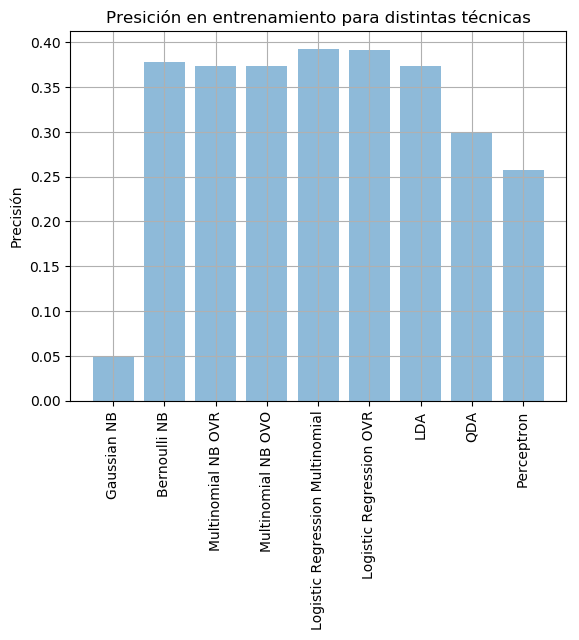

In [121]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
y_pos = np.arange(len(tecnicas))
 
plt.bar(y_pos, scores, align='center', alpha=0.5)
plt.xticks(y_pos, tecnicas)
plt.ylabel('Precisión')
plt.xticks(rotation=90)
plt.grid()
plt.title('Presición en entrenamiento para distintas técnicas')
 
plt.show()

De entre todos los valores **Gaussian Naive Bayes** obtuvo el peor score de accuracy sobre el set de entrenamiento seguido por **QDA** y luego **Perceptron**, el resto de los métodos no son muy diferenciables y de todos ellos se destaca la **regresión logistica multinomial** con un score de 0,3928.

Se debe destacar que los métodos **Gaussian y Bernoulli Naive Bayes** no funcionan optimamente en **analisis de texto muy extenso**, para eso existen los métodos **Multinomial Naive Bayes**

> **e) Utilice la técnica de ECOC (*Error-Correcting Output-Code*) para extender a multiclases algunos de los clasificadores utilizados en d). Comente lo que hace la técnica y los resultados observados.**

**Error Correcting Output-Code** es un método de clasificación para extender métodos de clasificación binarios a métodos de multiples clases. Esto se realiza combinando métodos binarios.

El algoritmo funciona con 2 etapas:
- Se construyen multiples clasificadores independientes entre si, cada uno responsable de determinar que tanto pertenece un input a una clase.

- Se realiza un esquema de votación para decidir la clase correcta de acuerdo al output de cada learner.

In [73]:
print("Multinomial Naive Bayes ECOC:")
mnbe = do_MNaiveB(features_train, labels_train, "ecoc")

print(accuracy_score(labels_train, mnbe.predict(features_train.todense())))

Multinomial Naive Bayes ECOC:
0.3661456705220381


In [74]:
ecocs = list()
ecocs_scores = list()

for i in range(20):
  ecocs.append(do_MNaiveB(features_train, labels_train, "ecoc", classifiers=i+1))

for i in ecocs:
  ecocs_scores.append(accuracy_score(labels_train, i.predict(features_train.todense())))
  
  
     

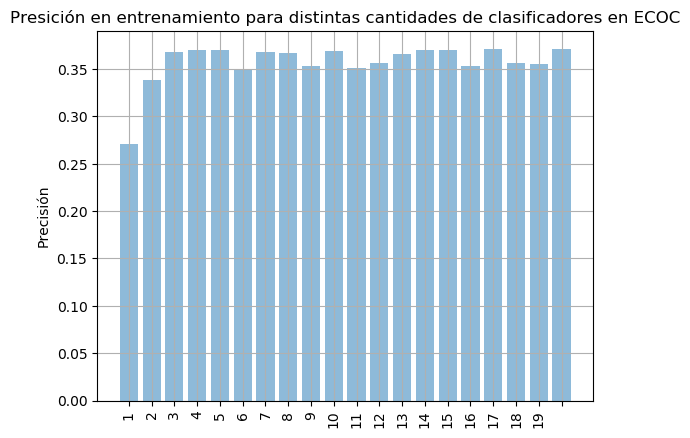

In [116]:
y2_pos = np.arange(len(ecocs_scores))
 
plt.bar(y2_pos, ecocs_scores, align='center', alpha=0.5)
plt.xticks(y2_pos, range(1,20))
plt.ylabel('Precisión')
plt.xticks(rotation=90)
plt.grid()
plt.title('Presición en entrenamiento para distintas cantidades de clasificadores en ECOC')
 
plt.show()

In [120]:
datas2 = {'Presición': ecocs_scores, 'Clasificadores': [1, 2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}

table2 = pd.DataFrame(data=datas2, columns=['Clasificadores', 'Presición'])
table2

,Clasificadores,Presición
0,1,0.270616
1,2,0.338950
2,3,0.368115
3,4,0.369709
4,5,0.369834
5,6,0.349859
6,7,0.367865
7,8,0.367146
8,9,0.353548
9,10,0.369115


El unico método que no puede resolver un problema de multiples clases por si solo corresponde al método Multinomial Naive Bayes, el resultado maximo entregado es de una precisión de 0,3717 en el conjunto de entrenamiento, este no supera al mayor de los analizados en el punto anterior correspondiente a la regresión logistica por método multinomial.

> **f) Evalúe la métrica de *accuracy* sobre el conjunto de pruebas del mejor clasificador encontrado.  
*Recuerde que puede acudir a otras métricas para tener otras visiones de lo que está haciendo el modelo de aprendizaje* **

El mejor clasificador corresponde a Logistic Regression Multinomial con una presición de 0,3927 en el conjunto de training.

In [77]:
print(accuracy_score(labels_test, lrm.predict(features_test)))
print(classification_report(labels_test, lrm.predict(features_test), digits=5, labels=labs, target_names=['neutral', 'worry', 'happiness', 'sadness', 'love', 'surprise', 'fun', 'relief', 'hate', 'empty', 'enthusiasm', 'boredom', 'anger']))

0.3466916354556804
              precision    recall  f1-score   support

     neutral    0.34178   0.63026   0.44321      1712
       worry    0.35066   0.40710   0.37678      1690
   happiness    0.32156   0.34533   0.33302      1028
     sadness    0.34642   0.24004   0.28358      1029
        love    0.49123   0.40526   0.44412       760
    surprise    0.20721   0.05145   0.08244       447
         fun    0.09574   0.02375   0.03805       379
      relief    0.23750   0.06109   0.09719       311
        hate    0.37500   0.18972   0.25197       253
       empty    0.00000   0.00000   0.00000       188
  enthusiasm    0.08333   0.00654   0.01212       153
     boredom    0.00000   0.00000   0.00000        42
       anger    0.00000   0.00000   0.00000        18

   micro avg    0.34669   0.34669   0.34669      8010
   macro avg    0.21926   0.18158   0.18173      8010
weighted avg    0.31817   0.34669   0.31390      8010



Como se destaco anteriormente, el learner obtuvo una muy mala presición para estados **como vacío, entusiasta, aburrido y enojado**, con los ultimos 2 y **vacío** con una presición de 0,0.

El estado mejor clasificado por el learner corresponde a **amor**, con casi un 0,5 de presición. A pesar de aparecer en menor cantidad que otro tipo de twits esto podría deberse a palabras especificas utilizadas en twits de este estilo.

In [78]:
print(df3.loc[df3['sentiment'] == 'love'].content)

16                                    @annarosekerr agreed
94       @RobertF3 correct! I ADORE him. I just plucked...
122      @freepbx sounds good. Appreciate the suggestio...
131      Pats in philly at 2 am. I love it. Mmm cheeses...
151      @NisforNeemah thanks neemah. I'm gonna be sooo...
210                          @bobbyedner i missed the game
397      @neyoofficial: love the song &quot;together&qu...
408      I want to go to Peru this summer ahhhhhhh! Hop...
438             Pug just woke me from an incredible sleep!
439      @ddlovato i can`t wait to hear your new album....
462      there's really no android twitter app of Tweet...
491      The pics I just uploaded are the baby pics of ...
619      Photo: martwo: OMG i love you!!!! i accadental...
651      good time Rocking out @ open mic, thanks 4 all...
660      @IkramShahnawaz Oh I love 'em, but when I thin...
682      @heresmyhello92 LOL, very true. Maybe next yea...
696                                    Hahaha! Alright  

> **g) Intente mejorar su resultado considerablemente a través de alguna mejora novedosa. Se espera que supere el 35% de *accuracy*.**

En lugar de utilizar CountVectorizer se utiliza TfidfVectorizer para normalizar los pesos de las ocurrencias de palabras e intentar no perder significado por apariciones excesivas de palabras.

Se reduce la minima cantidad de palabras necesarias para que se incluyan dentro del diccionario generado y se agrega un maximo de recurrencias para evitar que palabras muy comunes con poco significado tengan un gran peso en el modelo.

In [79]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer2 = TfidfVectorizer(min_df=25, max_df=0.4)

features_train2 = vectorizer2.fit_transform(texts_train)
features_test2 = vectorizer2.transform(texts_test)

Se intento cambiando algunos atributos como ajustar el intercepto, pero resulto en una alta disminución en la presición del modelo.

In [80]:
print("Logistic Regression:")
lrmb = do_LOGIT(features_train2, labels_train, mclass='multinomial', penal='l1', solv='saga') #solv = newton-bg liblinear saga
print(accuracy_score(labels_test, lrmb.predict(features_test2)))
print(classification_report(labels_test, lrmb.predict(features_test2), digits=5, labels=labs, target_names=['neutral', 'worry', 'happiness', 'sadness', 'love', 'surprise', 'fun', 'relief', 'hate', 'empty', 'enthusiasm', 'boredom', 'anger']))

Logistic Regression:
0.3540574282147316
              precision    recall  f1-score   support

     neutral    0.34467   0.60397   0.43888      1712
       worry    0.33664   0.44142   0.38198      1690
   happiness    0.33949   0.37549   0.35658      1028
     sadness    0.36156   0.26142   0.30344      1029
        love    0.51520   0.42368   0.46498       760
    surprise    0.27586   0.03579   0.06337       447
         fun    0.18966   0.02902   0.05034       379
      relief    0.23529   0.03859   0.06630       311
        hate    0.35455   0.15415   0.21488       253
       empty    0.00000   0.00000   0.00000       188
  enthusiasm    0.00000   0.00000   0.00000       153
     boredom    0.50000   0.02381   0.04545        42
       anger    0.00000   0.00000   0.00000        18

   micro avg    0.35406   0.35406   0.35406      8010
   macro avg    0.26561   0.18364   0.18355      8010
weighted avg    0.33092   0.35406   0.31878      8010



Se puede notar un aumento y disminución en la presición de algunos atributos, en este caso los twits relacionados con amor aumentaron su presición sobre 0,5.

# Referencias

[1] https://www.kaggle.com/toregil/new-labels-for-set-a  
[2] http://lcr.uns.edu.ar/fvc/NotasDeAplicacion/FVC-MartinTomas.pdf